# Feature Analysis

In [7]:
import pandas as pd
import math

In [8]:
filenames1 = ['pionminus','pionminus1','pionminus2','pionminus3','pionminus4','pionminus5']
filename2 = 'newDB'#'electron1'
filepath = "/home/yoren/bnl/PHENIX/ee/ML/"

In [9]:
if False:
    data1 = pd.read_csv(filepath+f'{filenames1[0]}.csv')
    data1.loc[data1['phi0'] > -99, 'phi0'] = 0
    for ifile in range(1,len(filenames1)):
        idata = pd.read_csv(filepath+f'{filenames1[ifile]}.csv')
        idata.loc[idata['phi0'] > -99, 'phi0'] = 0
        data1 = pd.concat([data1,idata], sort=False)
    data1 = pd.concat([data1,data1], sort=False)
    data1 = pd.concat([data1,data1], sort=False)
    data1 = pd.concat([data1,data1], sort=False)
    data1 = pd.concat([data1,data1], sort=False)

    data = pd.concat([data1,data2], sort=False)
    data = data.sample(frac = 1)
    data['phi0'] = data['phi0'].astype('int32')
    data['centrality'] = data['centrality'].astype('int32')
    data['zvertex'] = data['zvertex'].astype('float16')
    data['pt'] = data['pt'].astype('float16')
    data['e/p'] = data['e/p'].astype('float16')
    data['n0'] = data['n0'].astype('int32')
    data['disp'] = data['disp'].astype('float16')
    data['chi2'] = data['chi2'].astype('float16')
    data['npe0'] = data['npe0'].astype('int32')
    data['prob'] = data['prob'].astype('float16')
    data.head()
    
    data['disp2'] = data.apply(lambda row: row['disp']**2, axis=1)
    data['n0*disp'] = data.apply(lambda row: (row['n0']-2)/(1+row['disp']), axis=1)
    data['n0*disp2'] = data.apply(lambda row: (row['n0']-2)/(1+row['disp'])**0.5, axis=1)
    data['chi2/npe0'] = data.apply(lambda row: row['chi2']/(row['npe0']+0.001), axis=1)
    data['e/p*prob'] = data.apply(lambda row:  math.copysign(1,row['e/p']-0.8)*(row['e/p']-0.8)**2*(row['prob']), axis=1)
    data['n0*prob'] = data.apply(lambda row: (row['n0']-2)*(row['prob']+0.001), axis=1)
    data['prob-1'] = data.apply(lambda row: 1./(1.00001-row['prob'])**0.5, axis=1)
    data['e/p*pt'] = data.apply(lambda row: ((row['pt'])**0.5)*math.copysign(1,row['e/p']-0.8)*(row['e/p']-0.8)**2, axis=1)
    data['n0*pt'] = data.apply(lambda row: (row['n0']-2)*(row['pt']+0.001)**0.5, axis=1)
    #data['e/p*centrality'] = data.apply(lambda row: row['e/p']*(row['centrality']+0.001)**0.5, axis=1)
    #data['n0*centrality'] = data.apply(lambda row: row['n0']*(row['centrality']+0.001)**0.5, axis=1)
    data['n0-2'] = data.apply(lambda row: (row['n0']-2)*(row['n0']), axis=1)
    data['e/p-0.8'] = data.apply(lambda row: math.copysign(1,row['e/p']-0.8)*(row['e/p']-0.8)**2, axis=1)
    data['pt-1'] = data.apply(lambda row: row['pt']**-1, axis=1)
    data['pt2'] = data.apply(lambda row: row['pt']**2, axis=1)
    data['centrality-2'] = data.apply(lambda row: row['centrality']**-2, axis=1)
    data.head()

In [10]:
data = pd.read_csv(filepath+f'{filename2}.csv')
#data2.loc[data2['phi0'] > -99, 'phi0'] = 1
#data2 = data2[:100000]

In [11]:
print(data.size, data.shape)

341659176 (14235799, 24)


In [12]:
# удалим лишние колонки
data = data.drop(columns = ['zvertex'])

In [13]:
import matplotlib.pyplot as plt

def analysis(data: pd.DataFrame):
    fig, ax = plt.subplots(3, 3, figsize=(15, 6))
    for i, feature in enumerate(['centrality', 'pt', 'e/p', 'n0', 'disp', 'chi2', 'npe0', 'prob', 'phi0']):
        x, y = divmod(i, 3)
        data[feature].plot.hist(ax=ax[x][y], ylabel='', title=feature, color='skyblue', logy=True)


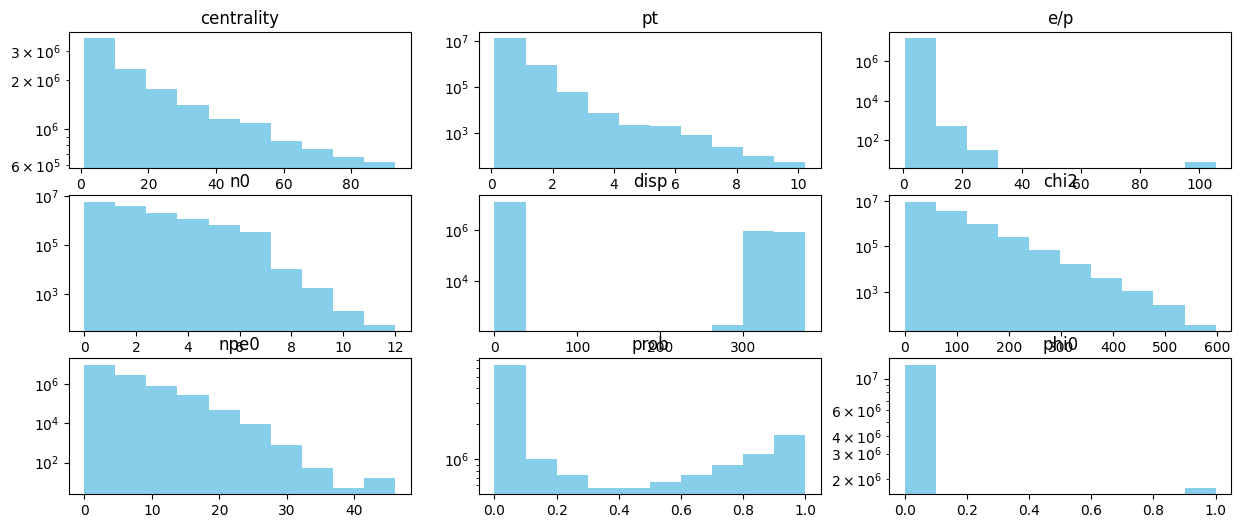

In [14]:
analysis(data)

+ Видим, что impressions имеют только одно значение, поэтому их можно удалить.
+ Таргет-переменная clicks сильно несбалансирована. Возможно, стоит использовать балансировку весов, а также в качестве оценки моделей использовать f1 и ROC AUC.
+ У campaign_clicks нулевых значений сильно больше, чем ненулевых, следовательно, можно трансформировать в бинарную фичу
+ os_id со значениями больше 6 встречается редко, можно объединить в одну категорию
+ Аналогично с редкими значениями zone_id

# Feature Engineering

In [15]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # делим выборку на train и test
    #data = data.sort_values(by='date_time', ignore_index=True)
    #cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    #cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    cut_off_val =  int (data.shape[0]/3)
    cut_off_test = int (data.shape[0]/3*2 + 1)

    print(cut_off_val,cut_off_test)

    y = data['phi0']
    data = data.drop(columns = ['phi0'])
    data_train, data_test = data[:cut_off_test], data[cut_off_test:]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    #enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    #enc.fit(data_train)
    #transformed_train = enc.transform(data_train)
    #transformed_test = enc.transform(data_test)
    
    return data_train, data_test, y_train, y_test,cut_off_val

In [16]:
X_train_all, X_test, y_train_all, y_test, cut_off_val = feature_engineering(data)

4745266 9490533


In [17]:
X_test

,centrality,pt,e/p,n0,disp,chi2,npe0,prob,disp2,n0*disp,...,e/p*prob,n0*prob,prob-1,e/p*pt,n0*pt,n0-2,e/p-0.8,pt-1,pt2,centrality-2
9490533,29,0.3477,0.9720,2,6.387,49.600,1,0.020360,40.790176,0.000000,...,0.000603,0.000000,1.010331,0.017478,0.000000,0.0,0.029642,2.876404,0.120865,0.001189
9490534,45,0.4900,0.7000,1,4.870,9.210,1,0.925300,23.727554,-0.170326,...,-0.009217,-0.926293,3.658392,-0.006973,-0.700707,-1.0,-0.009961,2.040857,0.240090,0.000494
9490535,6,0.5596,1.5530,0,336.500,42.530,0,0.000054,113232.250000,-0.005926,...,0.000030,-0.002108,1.000022,0.423849,-1.497425,-0.0,0.566609,1.787086,0.313119,0.027778
9490536,31,0.5425,0.6353,3,2.805,17.340,4,0.816000,7.866272,0.262834,...,-0.022145,0.816918,2.330679,-0.019990,0.737211,3.0,-0.027141,1.843384,0.294285,0.001041
9490537,14,0.4873,0.7120,1,6.010,14.770,2,0.560500,36.140762,-0.142618,...,-0.004349,-0.561547,1.508477,-0.005416,-0.698788,-1.0,-0.007759,2.052104,0.237466,0.005102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14235794,52,0.5060,1.1630,1,9.130,100.750,2,0.000076,83.408264,-0.098689,...,0.000010,-0.001076,1.000033,0.093763,-0.711941,-1.0,0.131831,1.976834,0.255894,0.000370
14235795,57,0.5405,0.6500,0,343.800,13.840,0,0.000428,118164.062500,-0.005801,...,-0.000010,-0.002855,1.000209,-0.016564,-1.471771,-0.0,-0.022529,1.850045,0.292170,0.000308
14235796,47,0.5127,0.8594,1,8.100,0.617,2,0.013176,65.635315,-0.109871,...,0.000046,-0.014176,1.006649,0.002524,-0.716725,-1.0,0.003525,1.950476,0.262856,0.000453
14235797,31,0.5757,0.9940,1,8.664,27.470,1,0.007748,75.065979,-0.103476,...,0.000292,-0.008748,1.003891,0.028597,-0.759397,-1.0,0.037691,1.737065,0.331412,0.001041


In [18]:
X_train, X_val = X_train_all[:cut_off_val], X_train_all[cut_off_val:]
y_train, y_val = y_train_all[:cut_off_val], y_train_all[cut_off_val:]

+ Увидели, что количество кликов меняется в зависимости от дня недели и часа, добавим в качестве фичей
+ Также, добавим интеракции между этими двумя переменными, так как в разные дни недели разные часы могут по-разному влиять на колличество кликов
+ banner_id удалила, так как предполагаю, что модель должна уметь предсказывать клики для новых баннеров тоже.
+ Так как все оставшиеся фичи являются категориальными, сделали one-hot-encoding


+ В качестве теста берем последний день датасета, в качестве валидации -- предпоследний

# Create Model

In [19]:
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate= 0.1, max_features=2, max_depth=2, random_state=0)
gb_clf.fit(X_train, y_train)

predicted = gb_clf.predict(X_test)

# calculating the main quality metrics
print(metrics.classification_report(y_test, predicted))

print('confusion matrix')
print(metrics.confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96   4169886
           1       0.86      0.50      0.63    575380

    accuracy                           0.93   4745266
   macro avg       0.90      0.75      0.80   4745266
weighted avg       0.93      0.93      0.92   4745266

confusion matrix
[[4123851   46035]
 [ 286573  288807]]


In [20]:
# search for parameters
# https://www.kaggle.com/hatone/gradientboostingclassifier-with-gridsearchcv
import time
from sklearn.model_selection import GridSearchCV

start = time.time() 

parameters = {
    "loss":["log_loss"],
    "learning_rate": [0.01, 0.2],
    "min_samples_split": [0.01, 0.2],
    "max_depth":[3,8],
    "max_features":["log2","sqrt"],
    "criterion": ['squared_error'],
    "n_estimators":[10]
    }

classif = GradientBoostingClassifier()
classif.set_params(init='zero')

clf = GridSearchCV(classif, parameters, cv=3, n_jobs=4)

clf.fit(X_train, y_train)
print('точность: ', clf.score(X_test, y_test))

# getting the best parameters ans score
print(clf.best_params_)
print(clf.best_score_)

stop = time.time()    
print('time of execution (sec)', stop - start)

точность:  0.9453259311490652
{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 0.01, 'n_estimators': 10}
0.9453980029497432
time of execution (sec) 626.7457938194275


# Cross Validation

In [21]:
predicted = clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97   4169886
           1       0.84      0.67      0.75    575380

    accuracy                           0.95   4745266
   macro avg       0.90      0.83      0.86   4745266
weighted avg       0.94      0.95      0.94   4745266



In [22]:
y_pred_probs = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

# Model Evaluation

log loss: 0.18805992972143493
roc auc: 0.962664650971567
f1 score: 0.6905398779525679


Text(0.5, 1.0, 'ROC AUC Curve')

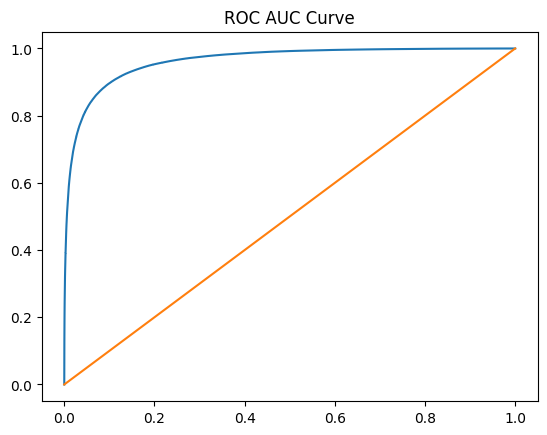

In [23]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score

print('log loss:', log_loss(y_test, y_pred_probs))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.title('ROC AUC Curve')

In [24]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.36941503874780507


In [25]:
i = 56000
print(round(tpr[i],3),round(fpr[i]/tpr[i],4))
print(thresholds[i],fpr[i],tpr[i])
#print((fpr[i]/tpr[i]*data1.shape[0]/data2.shape[0]/10)**-1,(fpr[i]/1.*data1.shape[0]/data2.shape[0]/10)**-1)

0.61 0.0188
0.5861701010286556 0.011490961623411287 0.610436581042094


In [26]:
print(sum(predicted),len(predicted))

459871 4745266


In [27]:
kek_data = data
kek_data = kek_data.drop(columns = ['phi0'])
proba_loc = clf.predict_proba(kek_data)
print(proba_loc[0][1])

0.08260388296612693


In [28]:
mycute,mycuth, AIcute, AIcuth = 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = data.reset_index()  # make sure indexes pair with number of rows

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>100000: break
    centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 = row['centrality'], row['pt'], row['e/p'], row['n0'], row['disp'], row['chi2'], row['npe0'], row['prob'], row['phi0']
    if pt<0.4 or centrality<0: continue
    if ep>0.8 and n0>=2+disp**2/8 and prob>0.01 and chi2/(npe0+1e-4)<10: 
        if phi0: mycute+=1
        else: mycuth+=1
    if proba_loc[counter][1]>thresholds[i]: 
        if phi0: AIcute+=1
        else: AIcuth+=1
    if phi0: norm_e+=1
    else: norm_h+=1
    #if counter<10: 
    #    print(proba_loc[counter],answer(centrality,pt,ep,n0,disp,chi2,npe0,prob))
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )

In [29]:
print(norm_e, norm_h,round(mycute/norm_e,3),round(mycuth/norm_h,3), round(AIcute/norm_e,3), round(AIcuth/norm_h,3), round(AIcuth/AIcute/norm_h*norm_e,3),round(fpr[i]/tpr[i],3))

10684 83748 0.523 0.013 0.622 0.011 0.018 0.019


In [30]:
print(round(AIcute/mycute/(AIcuth/mycuth),3),round(AIcute/mycute,3),round(AIcuth/mycuth,3), round(30*AIcute/norm_e/AIcuth*norm_h))

1.434 1.19 0.83 1697


In [31]:
import pickle
with open('output/bdt.pkl','wb') as f:
    pickle.dump(clf,f)

print(clf.predict(kek_data[0:10]))

[0 0 0 0 0 0 0 0 0 1]


In [32]:
import pickle
# load
with open('output/bdt.pkl', 'rb') as f:
    clf2 = pickle.load(f)
print(clf2.predict(kek_data[0:10]))

[0 0 0 0 0 0 0 0 0 1]


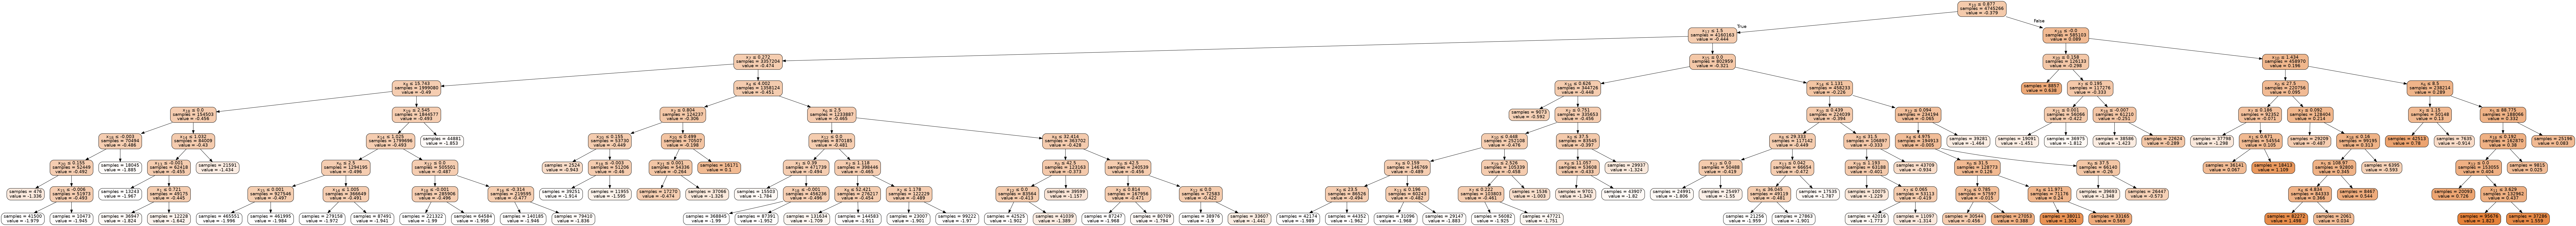

In [33]:
sub_tree_42 = clf2.best_estimator_[0, 0]
from sklearn.tree import export_graphviz, export_text
from sklearn.tree import _tree
# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)

graph = graph_from_dot_data(dot_data)
png = graph.create_png()
# Save (optional)
from pathlib import Path
Path('output/out.png').write_bytes(png)
# Display
Image(png)

In [34]:
clf2.predict(kek_data[0:100])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [35]:

clf2.predict_proba(kek_data[0:100])


array([[0.91739612, 0.08260388],
       [0.88962523, 0.11037477],
       [0.92918453, 0.07081547],
       [0.88939982, 0.11060018],
       [0.6190798 , 0.3809202 ],
       [0.92650791, 0.07349209],
       [0.93115131, 0.06884869],
       [0.89027943, 0.10972057],
       [0.92791079, 0.07208921],
       [0.35026993, 0.64973007],
       [0.89494559, 0.10505441],
       [0.90437676, 0.09562324],
       [0.35591742, 0.64408258],
       [0.88797341, 0.11202659],
       [0.14661931, 0.85338069],
       [0.93151665, 0.06848335],
       [0.90846937, 0.09153063],
       [0.93196505, 0.06803495],
       [0.87391802, 0.12608198],
       [0.81760029, 0.18239971],
       [0.93297447, 0.06702553],
       [0.91807768, 0.08192232],
       [0.9288755 , 0.0711245 ],
       [0.91880821, 0.08119179],
       [0.27259215, 0.72740785],
       [0.92278916, 0.07721084],
       [0.93150737, 0.06849263],
       [0.92464797, 0.07535203],
       [0.9122815 , 0.0877185 ],
       [0.60032959, 0.39967041],
       [0.

In [36]:
print( clf2.best_params_)

{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 0.01, 'n_estimators': 10}


In [37]:
clf2.best_estimator_.predict_proba(kek_data[9:20])

array([[0.35026993, 0.64973007],
       [0.89494559, 0.10505441],
       [0.90437676, 0.09562324],
       [0.35591742, 0.64408258],
       [0.88797341, 0.11202659],
       [0.14661931, 0.85338069],
       [0.93151665, 0.06848335],
       [0.90846937, 0.09153063],
       [0.93196505, 0.06803495],
       [0.87391802, 0.12608198],
       [0.81760029, 0.18239971]])

In [38]:
y = clf2.best_estimator_[0, 0].predict(kek_data[9:19].values.tolist())*0
#y = gb_clf.decision_function(kek_data[9:20])

rate = clf2.best_params_['learning_rate']
print(rate)
for i in range(0,10):
    sub_tree = clf2.best_estimator_[i, 0]
    y += rate*sub_tree.predict(kek_data[9:19].values.tolist())
print(y)
print(gb_clf.decision_function(kek_data[9:20]))
z=y
for i in range(len(z)): 
    z[i] = 1./(1+np.exp(-z[i]))
print(z)

0.2
[ 0.6178529  -2.14228452 -2.24683015  0.5931282  -2.07020552  1.76136626
 -2.61022336 -2.29508748 -2.61727374 -1.9360542 ]
[-0.28671427 -3.04662793 -2.92444324  0.91554358 -2.69592242  0.73661448
 -3.44986944 -2.90255044 -3.47479277 -3.04662793 -1.22157685]
[0.64973007 0.10505441 0.09562324 0.64408258 0.11202659 0.85338069
 0.06848335 0.09153063 0.06803495 0.12608198]


In [39]:
best_gbc = clf2.best_estimator_

In [40]:
learning_rate = best_gbc.learning_rate
print(clf2.decision_function(kek_data[9:19]))
arr = clf2.decision_function(kek_data[9:19])
print(1./(1.+np.exp(-arr)))
#tree_scores = [best_gbc.estimators_[i, 0].decision_function(kek_data[9:19].values.tolist()) for i in range(10)]
print(learning_rate)

[ 0.6178529  -2.14228452 -2.24683015  0.5931282  -2.07020552  1.76136626
 -2.61022336 -2.29508748 -2.61727374 -1.9360542 ]
[0.64973007 0.10505441 0.09562324 0.64408258 0.11202659 0.85338069
 0.06848335 0.09153063 0.06803495 0.12608198]
0.2


In [41]:
log_odds_predictions = []
for tree in clf2.best_estimator_:
    # For each tree, get the predicted values for each sample
    leaf_indices = tree[0].apply(kek_data[9:19].values.tolist())  # Get the leaf indices for the training data
    leaf_values = tree[0].tree_.value  # Get the values at each leaf

    # Average the values for each leaf to interpret them as log odds
    predicted_log_odds = [leaf_values[leaf_indices[i]].mean() for i in range(len(kek_data[9:19]))]
    log_odds_predictions.append(predicted_log_odds)

In [42]:
print(log_odds_predictions)

[[1.3042014153797585, -1.7840417983616075, -1.9835582636175717, 0.08302905223051278, -1.8527662039615873, 1.4980066122131466, -1.9895999674660088, -1.9107778922833252, -1.99609065387036, -1.7840417983616075], [-0.15974468098272263, -1.5159645243203257, -1.6353688723756254, 1.4756268642721246, -1.1157744843737623, 1.020508093190928, -1.6673135878247167, -1.5902634935828532, -1.6673135878247167, -1.5159645243203257], [0.5803405512210023, -1.2522374733234978, -0.7640125645532604, 0.19059489596264906, -1.2113934769897698, 1.2928703006748448, -1.4654535370231776, -1.4166004327740964, -1.471309828929087, -1.0099724049877494], [-0.026069711692921778, -1.032597999098748, -1.2980835808532676, 0.29029680698978355, -1.2702662719224367, 0.7736506100976522, -1.3441510161935086, -1.1802363086607064, -1.3414320147862877, -1.032597999098748], [0.14537280613830844, -1.2506735030065614, -1.1164230227812906, 0.14537280613830844, -1.0928474709158489, 0.9537154895206974, -1.2506735030065614, -1.15174018990

In [43]:
rate = clf2.best_params_['learning_rate']
myarr = [log_odds_predictions[i][0] for i in range(10)]
print(rate,rate*sum(myarr))
print(clf2.decision_function(kek_data[9:19]))

0.2 0.6178529034837353
[ 0.6178529  -2.14228452 -2.24683015  0.5931282  -2.07020552  1.76136626
 -2.61022336 -2.29508748 -2.61727374 -1.9360542 ]


In [44]:
print(best_gbc.estimators_.shape[0])
print(best_gbc.estimators_.shape[1])
y = []
for i in range(10):
    y0=[]
    for j in range(10):
        sub_tree = clf2.best_estimator_[j, 0]
        y0.append(sub_tree.predict(kek_data[9+i:10+i].values.tolist())[0])
    y.append(y0)
print(y)

10
1
[[1.3042014153797585, -0.15974468098272263, 0.5803405512210023, -0.026069711692921778, 0.14537280613830844, -0.017352579456361004, 0.23649719593690338, 0.2621850560693795, 0.3270757182280309, 0.4367587465772985], [-1.7840417983616075, -1.5159645243203257, -1.2522374733234978, -1.032597999098748, -1.2506735030065614, -0.9262161012249925, -0.9213282403186493, -0.7328484763712162, -1.0541019046118212, -0.24141258443490304], [-1.9835582636175717, -1.6353688723756254, -0.7640125645532604, -1.2980835808532676, -1.1164230227812906, -1.1998954990492516, -1.0959185980297488, -0.7948901494749855, -1.02830345881198, -0.31769673427226547], [0.08302905223051278, 1.4756268642721246, 0.19059489596264906, 0.29029680698978355, 0.14537280613830844, 0.3510889695356413, 0.6722979700721083, -0.5225498190672146, 0.35970572767220393, -0.0798222525301186], [-1.8527662039615873, -1.1157744843737623, -1.2113934769897698, -1.2702662719224367, -1.0928474709158489, -0.6231664505536461, -0.46128979022046546, -

In [ ]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " && "
            rule += str(p)
        rule += "  "
        if class_names is None:
            rule += " y = "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [74]:
iestim = 1
sub_tree = clf2.best_estimator_[iestim, 0]
rules = get_rules(sub_tree, list(kek_data.columns), None)
print(f"double mytree{list(kek_data.columns)}")
print('{')
#for r in rules:
#    print("    ",r)
print ('return y;')
print('};')

double mytree['centrality', 'pt', 'e/p', 'n0', 'disp', 'chi2', 'npe0', 'prob', 'disp2', 'n0*disp', 'n0*disp2', 'chi2/npe0', 'e/p*prob', 'n0*prob', 'prob-1', 'e/p*pt', 'n0*pt', 'n0-2', 'e/p-0.8', 'pt-1', 'pt2', 'centrality-2']
{
return y;
};


In [92]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " : "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f"  # | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [97]:
print(f"def mytree( iestim,  x ) :")
for iestim in range(10):
    print(f"    if iestim == {iestim}:")
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(kek_data.columns), None)
    for r in rules:
        print("       ",r)
print ('    return y')

def mytree( iestim,  x ) :
    if iestim == 0:
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] <= 0.2716) and (x[8] > 15.74323) and (x[19] <= 2.54489) and (x[14] <= 1.02494) and (x[6] <= 2.5) and (x[15] <= 0.00053) :  return -1.99609065387036  # | based on 465,551 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] <= 0.2716) and (x[8] > 15.74323) and (x[19] <= 2.54489) and (x[14] <= 1.02494) and (x[6] <= 2.5) and (x[15] > 0.00053) :  return -1.9835582636175717  # | based on 461,995 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] > 0.2716) and (x[4] > 4.002) and (x[6] <= 2.5) and (x[12] <= 0.00028) and (x[1] > 0.39025) and (x[18] <= -0.00127) :  return -1.9895999674660088  # | based on 368,845 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] <= 0.2716) and (x[8] > 15.74323) and (x[19] <= 2.54489) and (x[14] <= 1.02494) and (x[6] > 2.5) and (x[14] <= 1.00507) :  return -1.971944203640949  # | based on 279,158 samples
       

In [98]:
def mytree( iestim,  x ) :
    if iestim == 0:
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] <= 0.2716) and (x[8] > 15.74323) and (x[19] <= 2.54489) and (x[14] <= 1.02494) and (x[6] <= 2.5) and (x[15] <= 0.00053) :  return -1.99609065387036  # | based on 465,551 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] <= 0.2716) and (x[8] > 15.74323) and (x[19] <= 2.54489) and (x[14] <= 1.02494) and (x[6] <= 2.5) and (x[15] > 0.00053) :  return -1.9835582636175717  # | based on 461,995 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] > 0.2716) and (x[4] > 4.002) and (x[6] <= 2.5) and (x[12] <= 0.00028) and (x[1] > 0.39025) and (x[18] <= -0.00127) :  return -1.9895999674660088  # | based on 368,845 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] <= 0.2716) and (x[8] > 15.74323) and (x[19] <= 2.54489) and (x[14] <= 1.02494) and (x[6] > 2.5) and (x[14] <= 1.00507) :  return -1.971944203640949  # | based on 279,158 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] <= 0.2716) and (x[8] > 15.74323) and (x[19] <= 2.54489) and (x[14] > 1.02494) and (x[12] <= 0.00017) and (x[18] <= -0.00097) :  return -1.9899512926866736  # | based on 221,322 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] > 0.2716) and (x[4] > 4.002) and (x[6] <= 2.5) and (x[12] > 0.00028) and (x[2] <= 1.1185) and (x[8] > 52.421) :  return -1.9107778922833252  # | based on 144,583 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] <= 0.2716) and (x[8] > 15.74323) and (x[19] <= 2.54489) and (x[14] > 1.02494) and (x[12] > 0.00017) and (x[16] <= -0.31387) :  return -1.9458144594642797  # | based on 140,185 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] > 0.2716) and (x[4] > 4.002) and (x[6] <= 2.5) and (x[12] > 0.00028) and (x[2] <= 1.1185) and (x[8] <= 52.421) :  return -1.7094063843687801  # | based on 131,634 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] > 0.2716) and (x[4] > 4.002) and (x[6] <= 2.5) and (x[12] > 0.00028) and (x[2] > 1.1185) and (x[2] > 1.1775) :  return -1.9704501017919414  # | based on 99,222 samples
        if (x[10] > 0.87684) and (x[18] > -0.00036) and (x[10] > 1.43386) and (x[6] > 8.5) and (x[5] <= 88.775) and (x[18] <= 0.19166) and (x[12] > 0.00018) and (x[11] <= 3.62937) :  return 1.8227350641749236  # | based on 95,676 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] <= 0.2716) and (x[8] > 15.74323) and (x[19] <= 2.54489) and (x[14] <= 1.02494) and (x[6] > 2.5) and (x[14] > 1.00507) :  return -1.940519596301334  # | based on 87,491 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] > 0.2716) and (x[4] > 4.002) and (x[6] <= 2.5) and (x[12] <= 0.00028) and (x[1] > 0.39025) and (x[18] > -0.00127) :  return -1.9520316737421473  # | based on 87,391 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] > 0.2716) and (x[4] > 4.002) and (x[6] > 2.5) and (x[8] > 32.41434) and (x[0] <= 42.5) and (x[2] <= 0.81375) :  return -1.968044746524236  # | based on 87,247 samples
        if (x[10] > 0.87684) and (x[18] > -0.00036) and (x[10] <= 1.43386) and (x[0] > 27.5) and (x[7] > 0.09232) and (x[18] <= 0.15977) and (x[5] <= 108.97) and (x[4] <= 4.834) :  return 1.4980066122131466  # | based on 82,272 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] > 0.2716) and (x[4] > 4.002) and (x[6] > 2.5) and (x[8] > 32.41434) and (x[0] <= 42.5) and (x[2] > 0.81375) :  return -1.7939263279188193  # | based on 80,709 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] <= 0.2716) and (x[8] > 15.74323) and (x[19] <= 2.54489) and (x[14] > 1.02494) and (x[12] > 0.00017) and (x[16] > -0.31387) :  return -1.8364437728245813  # | based on 79,410 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] <= 0.2716) and (x[8] > 15.74323) and (x[19] <= 2.54489) and (x[14] > 1.02494) and (x[12] <= 0.00017) and (x[18] > -0.00097) :  return -1.9555307816177379  # | based on 64,584 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] <= 0.00012) and (x[16] > 0.62629) and (x[2] <= 0.75125) and (x[10] > 0.44752) and (x[19] <= 2.52606) and (x[7] <= 0.22235) :  return -1.92518098498627  # | based on 56,082 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] <= 0.00012) and (x[16] > 0.62629) and (x[2] <= 0.75125) and (x[10] > 0.44752) and (x[19] <= 2.52606) and (x[7] > 0.22235) :  return -1.7508015339158862  # | based on 47,721 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] <= 0.2716) and (x[8] > 15.74323) and (x[19] > 2.54489) :  return -1.8527662039615873  # | based on 44,881 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] <= 0.00012) and (x[16] > 0.62629) and (x[2] <= 0.75125) and (x[10] <= 0.44752) and (x[9] <= 0.15896) and (x[0] > 23.5) :  return -1.962301587301587  # | based on 44,352 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] <= 0.00012) and (x[16] > 0.62629) and (x[2] > 0.75125) and (x[0] <= 37.5) and (x[8] > 11.05692) :  return -1.820165349488692  # | based on 43,907 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] > 0.00012) and (x[14] <= 1.13052) and (x[10] > 0.43881) and (x[0] > 31.5) :  return -0.9343155871788419  # | based on 43,709 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] > 0.2716) and (x[4] > 4.002) and (x[6] > 2.5) and (x[8] <= 32.41434) and (x[0] <= 42.5) and (x[12] <= 0.00036) :  return -1.9024573780129335  # | based on 42,525 samples
        if (x[10] > 0.87684) and (x[18] > -0.00036) and (x[10] > 1.43386) and (x[6] <= 8.5) and (x[2] <= 1.1495) :  return 0.7795733069884506  # | based on 42,513 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] <= 0.00012) and (x[16] > 0.62629) and (x[2] <= 0.75125) and (x[10] <= 0.44752) and (x[9] <= 0.15896) and (x[0] <= 23.5) :  return -1.9892824963247497  # | based on 42,174 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] > 0.00012) and (x[14] <= 1.13052) and (x[10] > 0.43881) and (x[0] <= 31.5) and (x[19] > 1.19313) and (x[7] <= 0.06515) :  return -1.7729436405178978  # | based on 42,016 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] <= 0.2716) and (x[8] <= 15.74323) and (x[18] <= 9e-05) and (x[18] <= -0.00293) and (x[20] > 0.1546) and (x[15] <= -0.00621) :  return -1.9792771084337348  # | based on 41,500 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] > 0.2716) and (x[4] > 4.002) and (x[6] > 2.5) and (x[8] <= 32.41434) and (x[0] <= 42.5) and (x[12] > 0.00036) :  return -1.389166402690124  # | based on 41,039 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] > 0.00012) and (x[14] > 1.13052) and (x[12] <= 0.09384) and (x[4] > 4.975) and (x[0] <= 37.5) :  return -1.3480966417252411  # | based on 39,693 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] > 0.2716) and (x[4] > 4.002) and (x[6] > 2.5) and (x[8] <= 32.41434) and (x[0] > 42.5) :  return -1.1572514457435794  # | based on 39,599 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] > 0.00012) and (x[14] > 1.13052) and (x[12] > 0.09384) :  return -1.4637611058781599  # | based on 39,281 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] > 0.2716) and (x[4] <= 4.002) and (x[2] <= 0.80435) and (x[20] > 0.1546) and (x[18] <= -0.00278) :  return -1.914091360729663  # | based on 39,251 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] > 0.2716) and (x[4] > 4.002) and (x[6] > 2.5) and (x[8] > 32.41434) and (x[0] > 42.5) and (x[12] <= 0.00047) :  return -1.8997331691297208  # | based on 38,976 samples
        if (x[10] > 0.87684) and (x[18] <= -0.00036) and (x[20] > 0.15827) and (x[7] > 0.1949) and (x[18] <= -0.00672) :  return -1.423003161768517  # | based on 38,586 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] > 0.00012) and (x[14] > 1.13052) and (x[12] <= 0.09384) and (x[4] <= 4.975) and (x[0] > 31.5) and (x[8] <= 11.97133) :  return 1.3042014153797588  # | based on 38,011 samples
        if (x[10] > 0.87684) and (x[18] > -0.00036) and (x[10] <= 1.43386) and (x[0] <= 27.5) and (x[7] <= 0.18595) :  return -1.2984814011323351  # | based on 37,798 samples
        if (x[10] > 0.87684) and (x[18] > -0.00036) and (x[10] > 1.43386) and (x[6] > 8.5) and (x[5] <= 88.775) and (x[18] <= 0.19166) and (x[12] > 0.00018) and (x[11] > 3.62937) :  return 1.5588692806951672  # | based on 37,286 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] > 0.2716) and (x[4] <= 4.002) and (x[2] > 0.80435) and (x[20] <= 0.49886) and (x[21] > 0.00051) :  return -1.3262828468137917  # | based on 37,066 samples
        if (x[10] > 0.87684) and (x[18] <= -0.00036) and (x[20] > 0.15827) and (x[7] <= 0.1949) and (x[21] > 0.00071) :  return -1.8124137931034483  # | based on 36,975 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] <= 0.2716) and (x[8] <= 15.74323) and (x[18] > 9e-05) and (x[14] <= 1.03209) and (x[13] > -0.0005) and (x[1] <= 0.72085) :  return -1.8242888461850757  # | based on 36,947 samples
        if (x[10] > 0.87684) and (x[18] > -0.00036) and (x[10] <= 1.43386) and (x[0] <= 27.5) and (x[7] > 0.18595) and (x[1] <= 0.6707) :  return 0.06723665642898646  # | based on 36,141 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] > 0.2716) and (x[4] > 4.002) and (x[6] > 2.5) and (x[8] > 32.41434) and (x[0] > 42.5) and (x[12] > 0.00047) :  return -1.4405927336566786  # | based on 33,607 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] > 0.00012) and (x[14] > 1.13052) and (x[12] <= 0.09384) and (x[4] <= 4.975) and (x[0] > 31.5) and (x[8] > 11.97133) :  return 0.5692145333936379  # | based on 33,165 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] <= 0.00012) and (x[16] > 0.62629) and (x[2] <= 0.75125) and (x[10] <= 0.44752) and (x[9] > 0.15896) and (x[13] <= 0.19625) :  return -1.9680987908412657  # | based on 31,096 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] > 0.00012) and (x[14] > 1.13052) and (x[12] <= 0.09384) and (x[4] <= 4.975) and (x[0] <= 31.5) and (x[16] <= 0.78485) :  return -0.4563907805133578  # | based on 30,544 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] <= 0.00012) and (x[16] > 0.62629) and (x[2] > 0.75125) and (x[0] > 37.5) :  return -1.3236463239469554  # | based on 29,937 samples
        if (x[10] > 0.87684) and (x[18] > -0.00036) and (x[10] <= 1.43386) and (x[0] > 27.5) and (x[7] <= 0.09232) :  return -0.4874524975178884  # | based on 29,209 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] <= 0.00012) and (x[16] > 0.62629) and (x[2] <= 0.75125) and (x[10] <= 0.44752) and (x[9] > 0.15896) and (x[13] > 0.19625) :  return -1.8833499159433218  # | based on 29,147 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] > 0.00012) and (x[14] <= 1.13052) and (x[10] <= 0.43881) and (x[8] > 29.33323) and (x[13] <= 0.04182) and (x[5] > 36.045) :  return -1.9006567849836702  # | based on 27,863 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] > 0.00012) and (x[14] > 1.13052) and (x[12] <= 0.09384) and (x[4] <= 4.975) and (x[0] <= 31.5) and (x[16] > 0.78485) :  return 0.38805308098916935  # | based on 27,053 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] > 0.00012) and (x[14] > 1.13052) and (x[12] <= 0.09384) and (x[4] > 4.975) and (x[0] > 37.5) :  return -0.5734487843611752  # | based on 26,447 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] > 0.00012) and (x[14] <= 1.13052) and (x[10] <= 0.43881) and (x[8] <= 29.33323) and (x[12] > 0.00016) :  return -1.5500647134957053  # | based on 25,497 samples
        if (x[10] > 0.87684) and (x[18] > -0.00036) and (x[10] > 1.43386) and (x[6] > 8.5) and (x[5] > 88.775) :  return 0.08302905223051277  # | based on 25,196 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] > 0.00012) and (x[14] <= 1.13052) and (x[10] <= 0.43881) and (x[8] <= 29.33323) and (x[12] <= 0.00016) :  return -1.8058501060381738  # | based on 24,991 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] > 0.2716) and (x[4] > 4.002) and (x[6] <= 2.5) and (x[12] > 0.00028) and (x[2] > 1.1185) and (x[2] <= 1.1775) :  return -1.9010735862998218  # | based on 23,007 samples
        if (x[10] > 0.87684) and (x[18] <= -0.00036) and (x[20] > 0.15827) and (x[7] > 0.1949) and (x[18] > -0.00672) :  return -0.2894271570014144  # | based on 22,624 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] <= 0.2716) and (x[8] <= 15.74323) and (x[18] > 9e-05) and (x[14] > 1.03209) :  return -1.433652910935112  # | based on 21,591 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] > 0.00012) and (x[14] <= 1.13052) and (x[10] <= 0.43881) and (x[8] > 29.33323) and (x[13] <= 0.04182) and (x[5] <= 36.045) :  return -1.9591644712081295  # | based on 21,256 samples
        if (x[10] > 0.87684) and (x[18] > -0.00036) and (x[10] > 1.43386) and (x[6] > 8.5) and (x[5] <= 88.775) and (x[18] <= 0.19166) and (x[12] <= 0.00018) :  return 0.7263225999104166  # | based on 20,093 samples
        if (x[10] > 0.87684) and (x[18] <= -0.00036) and (x[20] > 0.15827) and (x[7] <= 0.1949) and (x[21] <= 0.00071) :  return -1.4506311874705358  # | based on 19,091 samples
        if (x[10] > 0.87684) and (x[18] > -0.00036) and (x[10] <= 1.43386) and (x[0] <= 27.5) and (x[7] > 0.18595) and (x[1] > 0.6707) :  return 1.1091076956498127  # | based on 18,413 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] <= 0.2716) and (x[8] <= 15.74323) and (x[18] <= 9e-05) and (x[18] > -0.00293) :  return -1.8849542809642563  # | based on 18,045 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] > 0.00012) and (x[14] <= 1.13052) and (x[10] <= 0.43881) and (x[8] > 29.33323) and (x[13] > 0.04182) :  return -1.787168520102652  # | based on 17,535 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] > 0.2716) and (x[4] <= 4.002) and (x[2] > 0.80435) and (x[20] <= 0.49886) and (x[21] <= 0.00051) :  return -0.47388535031847134  # | based on 17,270 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] > 0.2716) and (x[4] <= 4.002) and (x[2] > 0.80435) and (x[20] > 0.49886) :  return 0.09956094242780285  # | based on 16,171 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] > 0.2716) and (x[4] > 4.002) and (x[6] <= 2.5) and (x[12] <= 0.00028) and (x[1] <= 0.39025) :  return -1.7840417983616075  # | based on 15,503 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] <= 0.2716) and (x[8] <= 15.74323) and (x[18] > 9e-05) and (x[14] <= 1.03209) and (x[13] <= -0.0005) :  return -1.9673789926753757  # | based on 13,243 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] <= 0.2716) and (x[8] <= 15.74323) and (x[18] > 9e-05) and (x[14] <= 1.03209) and (x[13] > -0.0005) and (x[1] > 0.72085) :  return -1.64213280994439  # | based on 12,228 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] > 0.2716) and (x[4] <= 4.002) and (x[2] <= 0.80435) and (x[20] > 0.1546) and (x[18] > -0.00278) :  return -1.5951484734420744  # | based on 11,955 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] > 0.00012) and (x[14] <= 1.13052) and (x[10] > 0.43881) and (x[0] <= 31.5) and (x[19] > 1.19313) and (x[7] > 0.06515) :  return -1.3136883842479952  # | based on 11,097 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] <= 0.2716) and (x[8] <= 15.74323) and (x[18] <= 9e-05) and (x[18] <= -0.00293) and (x[20] > 0.1546) and (x[15] > -0.00621) :  return -1.945383366752602  # | based on 10,473 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] > 0.00012) and (x[14] <= 1.13052) and (x[10] > 0.43881) and (x[0] <= 31.5) and (x[19] <= 1.19313) :  return -1.229379652605459  # | based on 10,075 samples
        if (x[10] > 0.87684) and (x[18] > -0.00036) and (x[10] > 1.43386) and (x[6] > 8.5) and (x[5] <= 88.775) and (x[18] > 0.19166) :  return 0.024656138563423333  # | based on 9,815 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] <= 0.00012) and (x[16] > 0.62629) and (x[2] > 0.75125) and (x[0] <= 37.5) and (x[8] <= 11.05692) :  return -1.3431604989176373  # | based on 9,701 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] <= 0.00012) and (x[16] <= 0.62629) :  return -0.5923068444836328  # | based on 9,073 samples
        if (x[10] > 0.87684) and (x[18] <= -0.00036) and (x[20] <= 0.15827) :  return 0.6379135147341086  # | based on 8,857 samples
        if (x[10] > 0.87684) and (x[18] > -0.00036) and (x[10] <= 1.43386) and (x[0] > 27.5) and (x[7] > 0.09232) and (x[18] <= 0.15977) and (x[5] > 108.97) :  return 0.5439943309318531  # | based on 8,467 samples
        if (x[10] > 0.87684) and (x[18] > -0.00036) and (x[10] > 1.43386) and (x[6] <= 8.5) and (x[2] > 1.1495) :  return -0.9139489194499019  # | based on 7,635 samples
        if (x[10] > 0.87684) and (x[18] > -0.00036) and (x[10] <= 1.43386) and (x[0] > 27.5) and (x[7] > 0.09232) and (x[18] > 0.15977) :  return -0.5932759968725567  # | based on 6,395 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] > 0.2716) and (x[4] <= 4.002) and (x[2] <= 0.80435) and (x[20] <= 0.1546) :  return -0.9429477020602218  # | based on 2,524 samples
        if (x[10] > 0.87684) and (x[18] > -0.00036) and (x[10] <= 1.43386) and (x[0] > 27.5) and (x[7] > 0.09232) and (x[18] <= 0.15977) and (x[5] <= 108.97) and (x[4] > 4.834) :  return 0.033964095099466275  # | based on 2,061 samples
        if (x[10] <= 0.87684) and (x[17] > 1.5) and (x[15] <= 0.00012) and (x[16] > 0.62629) and (x[2] <= 0.75125) and (x[10] > 0.44752) and (x[19] > 2.52606) :  return -1.0026041666666667  # | based on 1,536 samples
        if (x[10] <= 0.87684) and (x[17] <= 1.5) and (x[7] <= 0.2716) and (x[8] <= 15.74323) and (x[18] <= 9e-05) and (x[18] <= -0.00293) and (x[20] <= 0.1546) :  return -1.3361344537815125  # | based on 476 samples
    if iestim == 1:
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] <= 0.00124) and (x[20] > 0.15307) and (x[3] <= 1.5) and (x[2] <= 0.7347) and (x[16] <= -0.69502) and (x[6] <= 2.5) :  return -1.6673135878247167  # | based on 528,808 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] <= 0.00124) and (x[20] > 0.15307) and (x[3] > 1.5) and (x[18] <= -0.00184) and (x[19] <= 2.25737) and (x[2] <= 0.69465) :  return -1.6609270897391544  # | based on 357,601 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] <= 0.00124) and (x[20] > 0.15307) and (x[3] <= 1.5) and (x[2] > 0.7347) and (x[5] <= 58.36) and (x[4] > 7.568) :  return -1.667862999417854  # | based on 288,748 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] <= 0.00124) and (x[20] > 0.15307) and (x[3] > 1.5) and (x[18] > -0.00184) and (x[7] <= 0.07168) and (x[8] > 25.33314) :  return -1.6353688723756252  # | based on 268,325 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] <= 0.00124) and (x[20] > 0.15307) and (x[3] <= 1.5) and (x[2] > 0.7347) and (x[5] <= 58.36) and (x[4] <= 7.568) :  return -1.6498612130553652  # | based on 247,145 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] <= 0.00124) and (x[20] > 0.15307) and (x[3] > 1.5) and (x[18] <= -0.00184) and (x[19] <= 2.25737) and (x[2] > 0.69465) :  return -1.6326303972427172  # | based on 188,113 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] > 0.00124) and (x[6] <= 3.5) and (x[4] > 4.7015) and (x[1] <= 0.77765) and (x[15] <= 0.05281) and (x[4] > 6.588) :  return -1.5902634935828532  # | based on 179,146 samples
        if (x[16] > 0.95686) and (x[7] > 0.11996) and (x[15] > -0.00033) and (x[15] <= 0.13957) and (x[0] > 21.5) and (x[12] > 0.002) and (x[9] > 0.46641) and (x[2] <= 1.1205) :  return 1.4756268642721246  # | based on 163,627 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] > 0.00124) and (x[6] <= 3.5) and (x[4] > 4.7015) and (x[1] <= 0.77765) and (x[15] > 0.05281) and (x[8] > 52.421) :  return -1.6567404299379738  # | based on 150,850 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] > 0.00124) and (x[6] <= 3.5) and (x[4] > 4.7015) and (x[1] <= 0.77765) and (x[15] > 0.05281) and (x[8] <= 52.421) :  return -1.6247907454356414  # | based on 139,625 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] <= 0.00124) and (x[20] > 0.15307) and (x[3] > 1.5) and (x[18] > -0.00184) and (x[7] <= 0.07168) and (x[8] <= 25.33314) :  return -1.5391138193143687  # | based on 126,747 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] <= 0.00124) and (x[20] > 0.15307) and (x[3] <= 1.5) and (x[2] > 0.7347) and (x[5] > 58.36) and (x[6] > 0.5) :  return -1.609204668835608  # | based on 126,059 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] <= 0.00124) and (x[20] > 0.15307) and (x[3] > 1.5) and (x[18] > -0.00184) and (x[7] > 0.07168) and (x[21] > 0.00051) :  return -1.5149536889978543  # | based on 111,252 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] <= 0.00124) and (x[20] > 0.15307) and (x[3] <= 1.5) and (x[2] > 0.7347) and (x[5] > 58.36) and (x[6] <= 0.5) :  return -1.6519941670908553  # | based on 110,374 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] > 0.00124) and (x[6] <= 3.5) and (x[4] > 4.7015) and (x[1] <= 0.77765) and (x[15] <= 0.05281) and (x[4] <= 6.588) :  return -1.4305207819790557  # | based on 99,954 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] <= 0.00124) and (x[20] > 0.15307) and (x[3] <= 1.5) and (x[2] <= 0.7347) and (x[16] > -0.69502) and (x[20] > 0.16375) :  return -1.661104033990547  # | based on 98,442 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] > 0.00124) and (x[6] > 3.5) and (x[18] <= 0.09968) and (x[0] <= 36.5) and (x[1] <= 0.70625) and (x[9] <= 0.15297) :  return -1.233470334417862  # | based on 63,611 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] > 0.00124) and (x[6] > 3.5) and (x[18] > 0.09968) and (x[2] > 1.2015) and (x[10] <= 0.40451) and (x[1] > 0.38855) :  return -1.612020731943961  # | based on 62,086 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] <= 0.00124) and (x[20] > 0.15307) and (x[3] <= 1.5) and (x[2] <= 0.7347) and (x[16] <= -0.69502) and (x[6] > 2.5) :  return -1.6709294836707649  # | based on 61,122 samples
        if (x[16] > 0.95686) and (x[7] > 0.11996) and (x[15] > -0.00033) and (x[15] <= 0.13957) and (x[0] <= 21.5) and (x[11] <= 6.84303) and (x[6] > 6.5) and (x[10] > 0.89785) :  return 1.1759064507861887  # | based on 56,312 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] <= 0.00124) and (x[20] > 0.15307) and (x[3] > 1.5) and (x[18] <= -0.00184) and (x[19] > 2.25737) and (x[4] > 4.994) :  return -1.634870143100387  # | based on 49,673 samples
        if (x[16] <= 0.95686) and (x[9] > 0.19624) and (x[15] <= -0.00025) and (x[15] <= -0.0052) :  return -1.4939004200493786  # | based on 47,019 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] <= 0.00124) and (x[20] > 0.15307) and (x[3] > 1.5) and (x[18] > -0.00184) and (x[7] > 0.07168) and (x[21] <= 0.00051) :  return -1.257387405477598  # | based on 46,332 samples
        if (x[16] > 0.95686) and (x[7] > 0.11996) and (x[15] <= -0.00033) and (x[8] <= 9.48087) :  return -0.41047972770407776  # | based on 46,288 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] > 0.00124) and (x[6] <= 3.5) and (x[4] <= 4.7015) and (x[2] > 1.0975) :  return -1.5822237921906122  # | based on 45,508 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] > 0.00124) and (x[6] <= 3.5) and (x[4] > 4.7015) and (x[1] > 0.77765) and (x[21] > 0.00071) :  return -1.472239318246922  # | based on 44,627 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] > 0.00124) and (x[6] <= 3.5) and (x[4] <= 4.7015) and (x[2] <= 1.0975) and (x[21] > 0.00058) :  return -1.2431351983569578  # | based on 40,989 samples
        if (x[16] > 0.95686) and (x[7] <= 0.11996) and (x[12] > 0.00013) and (x[0] > 27.5) :  return 0.1103109473232715  # | based on 40,463 samples
        if (x[16] > 0.95686) and (x[7] <= 0.11996) and (x[12] <= 0.00013) and (x[4] > 2.772) and (x[8] > 16.3614) and (x[4] <= 5.068) :  return -1.524856107831556  # | based on 38,790 samples
        if (x[16] > 0.95686) and (x[7] > 0.11996) and (x[15] > -0.00033) and (x[15] <= 0.13957) and (x[0] <= 21.5) and (x[11] > 6.84303) :  return -0.3374647551143432  # | based on 38,766 samples
        if (x[16] <= 0.95686) and (x[9] > 0.19624) and (x[15] > -0.00025) and (x[14] <= 1.08626) and (x[14] <= 1.00908) :  return -1.3202298250022069  # | based on 38,597 samples
        if (x[16] > 0.95686) and (x[7] > 0.11996) and (x[15] > -0.00033) and (x[15] <= 0.13957) and (x[0] > 21.5) and (x[12] <= 0.002) and (x[10] > 0.95058) :  return 1.020508093190928  # | based on 38,335 samples
        if (x[16] > 0.95686) and (x[7] <= 0.11996) and (x[12] > 0.00013) and (x[0] <= 27.5) :  return -0.8947686257418093  # | based on 37,951 samples
        if (x[16] > 0.95686) and (x[7] <= 0.11996) and (x[12] <= 0.00013) and (x[4] <= 2.772) and (x[11] > 4.55888) :  return -1.2429521537828676  # | based on 37,936 samples
        if (x[16] <= 0.95686) and (x[9] > 0.19624) and (x[15] > -0.00025) and (x[14] > 1.08626) and (x[6] > 4.5) and (x[11] <= 14.35343) and (x[21] <= 0.00217) :  return 1.0453320968734892  # | based on 36,753 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] > 0.00124) and (x[6] > 3.5) and (x[18] <= 0.09968) and (x[0] > 36.5) and (x[4] > 5.2285) :  return -0.8409907661090575  # | based on 36,719 samples
        if (x[16] > 0.95686) and (x[7] > 0.11996) and (x[15] <= -0.00033) and (x[8] > 9.48087) and (x[20] > 0.15575) and (x[15] <= -0.00841) :  return -1.577678705019362  # | based on 36,602 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] <= 0.00124) and (x[20] <= 0.15307) and (x[10] <= -0.05197) :  return -1.5159645243203257  # | based on 31,431 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] > 0.00124) and (x[6] > 3.5) and (x[18] <= 0.09968) and (x[0] > 36.5) and (x[4] <= 5.2285) :  return 0.4232535375215492  # | based on 31,199 samples
        if (x[16] <= 0.95686) and (x[9] > 0.19624) and (x[15] > -0.00025) and (x[14] > 1.08626) and (x[6] <= 4.5) :  return -0.5830500332523829  # | based on 30,868 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] <= 0.00124) and (x[20] <= 0.15307) and (x[10] > -0.05197) :  return -1.1157744843737623  # | based on 30,542 samples
        if (x[16] > 0.95686) and (x[7] <= 0.11996) and (x[12] <= 0.00013) and (x[4] > 2.772) and (x[8] <= 16.3614) and (x[18] <= 3e-05) :  return -1.5132690409192835  # | based on 27,847 samples
        if (x[16] > 0.95686) and (x[7] > 0.11996) and (x[15] > -0.00033) and (x[15] <= 0.13957) and (x[0] > 21.5) and (x[12] > 0.002) and (x[9] <= 0.46641) and (x[1] > 0.72825) :  return 1.243242980983985  # | based on 26,797 samples
        if (x[16] > 0.95686) and (x[7] <= 0.11996) and (x[12] <= 0.00013) and (x[4] > 2.772) and (x[8] > 16.3614) and (x[4] > 5.068) and (x[19] <= 2.60975) and (x[4] > 5.818) :  return -1.6747409701014895  # | based on 26,484 samples
        if (x[16] > 0.95686) and (x[7] > 0.11996) and (x[15] > -0.00033) and (x[15] > 0.13957) :  return -0.8143772819521263  # | based on 25,826 samples
        if (x[16] > 0.95686) and (x[7] > 0.11996) and (x[15] <= -0.00033) and (x[8] > 9.48087) and (x[20] > 0.15575) and (x[15] > -0.00841) :  return -1.2415597163205006  # | based on 25,689 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] > 0.00124) and (x[6] > 3.5) and (x[18] > 0.09968) and (x[2] <= 1.2015) :  return -1.2913498643490215  # | based on 24,906 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] > 0.00124) and (x[6] <= 3.5) and (x[4] > 4.7015) and (x[1] > 0.77765) and (x[21] <= 0.00071) :  return -1.1460520146430466  # | based on 24,379 samples
        if (x[16] > 0.95686) and (x[7] > 0.11996) and (x[15] > -0.00033) and (x[15] <= 0.13957) and (x[0] > 21.5) and (x[12] > 0.002) and (x[9] <= 0.46641) and (x[1] <= 0.72825) :  return 0.2940475854840733  # | based on 24,160 samples
        if (x[16] <= 0.95686) and (x[9] > 0.19624) and (x[15] <= -0.00025) and (x[15] > -0.0052) :  return -1.0459439834431472  # | based on 24,134 samples
        if (x[16] > 0.95686) and (x[7] <= 0.11996) and (x[12] <= 0.00013) and (x[4] > 2.772) and (x[8] > 16.3614) and (x[4] > 5.068) and (x[19] <= 2.60975) and (x[4] <= 5.818) :  return -1.6196930332937243  # | based on 22,612 samples
        if (x[16] > 0.95686) and (x[7] <= 0.11996) and (x[12] <= 0.00013) and (x[4] <= 2.772) and (x[11] <= 4.55888) :  return -0.18945363120379383  # | based on 21,631 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] > 0.00124) and (x[6] <= 3.5) and (x[4] <= 4.7015) and (x[2] <= 1.0975) and (x[21] <= 0.00058) :  return -0.6276940381723547  # | based on 21,606 samples
        if (x[16] > 0.95686) and (x[7] <= 0.11996) and (x[12] <= 0.00013) and (x[4] > 2.772) and (x[8] <= 16.3614) and (x[18] > 3e-05) :  return -1.0805637057325665  # | based on 21,601 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] <= 0.00124) and (x[20] > 0.15307) and (x[3] > 1.5) and (x[18] <= -0.00184) and (x[19] > 2.25737) and (x[4] <= 4.994) :  return -1.550678720607398  # | based on 21,424 samples
        if (x[16] <= 0.95686) and (x[9] > 0.19624) and (x[15] > -0.00025) and (x[14] <= 1.08626) and (x[14] > 1.00908) :  return -0.7535620754366712  # | based on 19,975 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] > 0.00124) and (x[6] > 3.5) and (x[18] <= 0.09968) and (x[0] <= 36.5) and (x[1] > 0.70625) :  return -0.5159147812106053  # | based on 19,394 samples
        if (x[16] <= 0.95686) and (x[9] > 0.19624) and (x[15] > -0.00025) and (x[14] > 1.08626) and (x[6] > 4.5) and (x[11] <= 14.35343) and (x[21] > 0.00217) :  return 0.23860679550951516  # | based on 16,300 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] > 0.00124) and (x[6] > 3.5) and (x[18] <= 0.09968) and (x[0] <= 36.5) and (x[1] <= 0.70625) and (x[9] > 0.15297) :  return -0.7587938706900931  # | based on 14,116 samples
        if (x[16] > 0.95686) and (x[7] > 0.11996) and (x[15] > -0.00033) and (x[15] <= 0.13957) and (x[0] > 21.5) and (x[12] <= 0.002) and (x[10] <= 0.95058) :  return -0.24948330518542078  # | based on 12,765 samples
        if (x[16] <= 0.95686) and (x[9] > 0.19624) and (x[15] > -0.00025) and (x[14] > 1.08626) and (x[6] > 4.5) and (x[11] > 14.35343) :  return -0.15974468098272263  # | based on 12,596 samples
        if (x[16] > 0.95686) and (x[7] > 0.11996) and (x[15] > -0.00033) and (x[15] <= 0.13957) and (x[0] > 21.5) and (x[12] > 0.002) and (x[9] > 0.46641) and (x[2] > 1.1205) :  return 0.886480265730599  # | based on 10,772 samples
        if (x[16] > 0.95686) and (x[7] > 0.11996) and (x[15] > -0.00033) and (x[15] <= 0.13957) and (x[0] <= 21.5) and (x[11] <= 6.84303) and (x[6] <= 6.5) :  return -0.07075421226525272  # | based on 10,003 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] > 0.00124) and (x[6] > 3.5) and (x[18] > 0.09968) and (x[2] > 1.2015) and (x[10] <= 0.40451) and (x[1] <= 0.38855) :  return -1.509386452914115  # | based on 8,828 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] > 0.00124) and (x[6] > 3.5) and (x[18] > 0.09968) and (x[2] > 1.2015) and (x[10] > 0.40451) :  return -1.4676064233374417  # | based on 8,813 samples
        if (x[16] <= 0.95686) and (x[9] <= 0.19624) and (x[12] <= 0.00124) and (x[20] > 0.15307) and (x[3] <= 1.5) and (x[2] <= 0.7347) and (x[16] > -0.69502) and (x[20] <= 0.16375) :  return -1.6435477668136331  # | based on 8,177 samples
        if (x[16] > 0.95686) and (x[7] > 0.11996) and (x[15] > -0.00033) and (x[15] <= 0.13957) and (x[0] <= 21.5) and (x[11] <= 6.84303) and (x[6] > 6.5) and (x[10] <= 0.89785) :  return 0.053088250081076  # | based on 7,629 samples
        if (x[16] > 0.95686) and (x[7] > 0.11996) and (x[15] <= -0.00033) and (x[8] > 9.48087) and (x[20] <= 0.15575) :  return -0.11413744661752567  # | based on 3,115 samples
        if (x[16] > 0.95686) and (x[7] <= 0.11996) and (x[12] <= 0.00013) and (x[4] > 2.772) and (x[8] > 16.3614) and (x[4] > 5.068) and (x[19] > 2.60975) :  return -1.2501666597858458  # | based on 352 samples
    if iestim == 2:
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] <= 0.8283) and (x[0] <= 34.5) and (x[20] > 0.13798) and (x[2] <= 0.79175) and (x[10] <= 0.44282) and (x[7] > 0.11325) :  return -1.4654535370231776  # | based on 495,636 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] <= 0.8283) and (x[0] <= 34.5) and (x[20] > 0.13798) and (x[2] <= 0.79175) and (x[10] <= 0.44282) and (x[7] <= 0.11325) :  return -1.4782344464023052  # | based on 488,924 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] > 0.8283) and (x[8] > 12.40773) and (x[19] > 1.35584) and (x[14] <= 1.40176) and (x[4] > 5.6225) and (x[5] <= 59.955) :  return -1.4662147342633443  # | based on 482,594 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] <= 0.8283) and (x[0] > 34.5) and (x[12] <= 3e-05) and (x[6] <= 4.5) and (x[1] > 0.3893) and (x[7] > 0.03612) :  return -1.4402010158425351  # | based on 348,083 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] <= 0.8283) and (x[0] > 34.5) and (x[12] <= 3e-05) and (x[6] <= 4.5) and (x[1] > 0.3893) and (x[7] <= 0.03612) :  return -1.471309828929087  # | based on 242,726 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] > 0.8283) and (x[8] > 12.40773) and (x[19] > 1.35584) and (x[14] <= 1.40176) and (x[4] <= 5.6225) and (x[21] > 0.00041) :  return -1.4017079010839988  # | based on 204,943 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] > 0.8283) and (x[8] > 12.40773) and (x[19] > 1.35584) and (x[14] <= 1.40176) and (x[4] > 5.6225) and (x[5] > 59.955) :  return -1.4166004327740964  # | based on 194,455 samples
        if (x[13] > 0.29064) and (x[8] <= 13.66255) and (x[2] > 0.75125) and (x[15] <= 0.1537) and (x[9] > 0.56802) and (x[5] <= 109.725) and (x[11] <= 9.25462) and (x[4] <= 2.497) :  return 1.2928703006748448  # | based on 177,460 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] > 0.8283) and (x[8] > 12.40773) and (x[19] > 1.35584) and (x[14] > 1.40176) and (x[21] > 0.00048) and (x[6] <= 1.5) :  return -1.4337577790750828  # | based on 148,318 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] > 0.8283) and (x[8] > 12.40773) and (x[19] > 1.35584) and (x[14] > 1.40176) and (x[21] > 0.00048) and (x[6] > 1.5) :  return -1.2495812855830606  # | based on 129,046 samples
        if (x[13] > 0.29064) and (x[8] <= 13.66255) and (x[2] > 0.75125) and (x[15] <= 0.1537) and (x[9] <= 0.56802) and (x[11] <= 16.40155) and (x[15] > 0.00123) and (x[11] <= 9.98088) :  return 1.0271490438792883  # | based on 69,165 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] > 0.8283) and (x[8] > 12.40773) and (x[19] <= 1.35584) and (x[9] > -0.00267) and (x[21] > 0.00071) and (x[14] <= 1.23753) :  return -1.3611651067467747  # | based on 69,044 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] <= 0.8283) and (x[0] <= 34.5) and (x[20] > 0.13798) and (x[2] > 0.79175) and (x[6] <= 3.5) and (x[14] <= 1.09561) :  return -1.4768993578495424  # | based on 64,455 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] > 0.8283) and (x[8] > 12.40773) and (x[19] > 1.35584) and (x[14] > 1.40176) and (x[21] <= 0.00048) and (x[13] <= -0.49233) :  return -1.260040425519057  # | based on 64,022 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] > 0.8283) and (x[8] > 12.40773) and (x[19] > 1.35584) and (x[14] <= 1.40176) and (x[4] <= 5.6225) and (x[21] <= 0.00041) :  return -1.2113934769897698  # | based on 61,581 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] > 0.8283) and (x[8] > 12.40773) and (x[19] <= 1.35584) and (x[9] <= -0.00267) and (x[6] <= 0.5) and (x[12] <= 0.00569) :  return -1.4624302391227701  # | based on 60,648 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] > 0.8283) and (x[8] > 12.40773) and (x[19] <= 1.35584) and (x[9] <= -0.00267) and (x[6] > 0.5) and (x[10] <= -0.34697) :  return -1.2110684634805835  # | based on 54,707 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] <= 0.8283) and (x[0] > 34.5) and (x[12] <= 3e-05) and (x[6] > 4.5) and (x[1] > 0.39345) and (x[15] <= -0.00477) :  return -1.4291655364669165  # | based on 54,154 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] <= 0.8283) and (x[0] <= 34.5) and (x[20] > 0.13798) and (x[2] > 0.79175) and (x[6] <= 3.5) and (x[14] > 1.09561) :  return -1.4305316804501662  # | based on 48,612 samples
        if (x[13] > 0.29064) and (x[8] > 13.66255) and (x[9] <= 0.15985) and (x[2] > 0.84065) :  return -0.950346813787559  # | based on 46,541 samples
        if (x[13] <= 0.29064) and (x[6] > 7.5) and (x[0] > 38.5) and (x[4] > 3.628) :  return -0.9542048086013005  # | based on 46,374 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] > 0.8283) and (x[8] > 12.40773) and (x[19] <= 1.35584) and (x[9] > -0.00267) and (x[21] <= 0.00071) :  return -0.7640125645532604  # | based on 46,349 samples
        if (x[13] > 0.29064) and (x[8] <= 13.66255) and (x[2] > 0.75125) and (x[15] <= 0.1537) and (x[9] > 0.56802) and (x[5] <= 109.725) and (x[11] <= 9.25462) and (x[4] > 2.497) :  return 1.062229528717809  # | based on 44,104 samples
        if (x[13] <= 0.29064) and (x[6] > 7.5) and (x[0] <= 38.5) and (x[4] <= 2.921) :  return -0.44565378443550563  # | based on 41,977 samples
        if (x[13] > 0.29064) and (x[8] <= 13.66255) and (x[2] <= 0.75125) and (x[20] > 0.15575) and (x[11] > 5.39617) :  return -1.2232436484993057  # | based on 41,048 samples
        if (x[13] <= 0.29064) and (x[6] > 7.5) and (x[0] > 38.5) and (x[4] <= 3.628) :  return 0.3924930112062894  # | based on 40,987 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] > 0.8283) and (x[8] > 12.40773) and (x[19] > 1.35584) and (x[14] > 1.40176) and (x[21] <= 0.00048) and (x[13] > -0.49233) :  return -0.8591000492214002  # | based on 40,987 samples
        if (x[13] <= 0.29064) and (x[6] > 7.5) and (x[0] <= 38.5) and (x[4] > 2.921) and (x[7] <= 0.01437) and (x[8] > 19.39783) :  return -1.4268188811488733  # | based on 38,777 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] > 0.8283) and (x[8] > 12.40773) and (x[19] <= 1.35584) and (x[9] <= -0.00267) and (x[6] > 0.5) and (x[10] > -0.34697) :  return -1.3974717896692304  # | based on 35,036 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] <= 0.8283) and (x[0] > 34.5) and (x[12] <= 3e-05) and (x[6] > 4.5) and (x[1] > 0.39345) and (x[15] > -0.00477) :  return -1.2394139302266987  # | based on 34,513 samples
        if (x[13] > 0.29064) and (x[8] > 13.66255) and (x[9] > 0.15985) and (x[15] <= 0.0001) and (x[1] > 0.3966) and (x[5] <= 101.42) and (x[12] <= -0.0013) and (x[0] <= 40.5) :  return -1.3859626764799893  # | based on 34,037 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] <= 0.8283) and (x[0] <= 34.5) and (x[20] > 0.13798) and (x[2] > 0.79175) and (x[6] > 3.5) :  return -1.3654890674940139  # | based on 32,844 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] > 0.8283) and (x[8] <= 12.40773) and (x[2] <= 1.1165) and (x[21] > 0.00101) and (x[7] <= 0.05778) :  return -1.224921043476622  # | based on 31,879 samples
        if (x[13] > 0.29064) and (x[8] > 13.66255) and (x[9] <= 0.15985) and (x[2] <= 0.84065) and (x[1] > 0.39345) and (x[5] > 33.015) :  return -1.3679217008647282  # | based on 31,428 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] > 0.8283) and (x[8] <= 12.40773) and (x[2] <= 1.1165) and (x[21] <= 0.00101) and (x[12] > 0.00028) :  return 0.18132543729614833  # | based on 31,086 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] <= 0.8283) and (x[0] <= 34.5) and (x[20] > 0.13798) and (x[2] <= 0.79175) and (x[10] > 0.44282) and (x[7] <= 0.01586) :  return -1.4901927114696474  # | based on 31,006 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] > 0.8283) and (x[8] <= 12.40773) and (x[2] > 1.1165) and (x[10] > -0.23514) and (x[4] > 2.321) :  return -1.2472891625726346  # | based on 29,386 samples
        if (x[13] > 0.29064) and (x[8] > 13.66255) and (x[9] > 0.15985) and (x[15] > 0.0001) and (x[2] <= 1.1265) and (x[15] <= 0.00521) :  return -0.3836945677482554  # | based on 28,901 samples
        if (x[13] <= 0.29064) and (x[6] > 7.5) and (x[0] <= 38.5) and (x[4] > 2.921) and (x[7] > 0.01437) and (x[15] > -2e-05) :  return -0.8958096657551531  # | based on 28,251 samples
        if (x[13] > 0.29064) and (x[8] > 13.66255) and (x[9] > 0.15985) and (x[15] > 0.0001) and (x[2] <= 1.1265) and (x[15] > 0.00521) and (x[20] > 0.45109) :  return 0.8091264591111478  # | based on 28,123 samples
        if (x[13] > 0.29064) and (x[8] > 13.66255) and (x[9] > 0.15985) and (x[15] > 0.0001) and (x[2] <= 1.1265) and (x[15] > 0.00521) and (x[20] <= 0.45109) and (x[0] > 27.5) :  return 0.2103283983255599  # | based on 27,866 samples
        if (x[13] > 0.29064) and (x[8] > 13.66255) and (x[9] > 0.15985) and (x[15] > 0.0001) and (x[2] > 1.1265) :  return -1.141382770834895  # | based on 27,471 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] > 0.8283) and (x[8] <= 12.40773) and (x[2] <= 1.1165) and (x[21] > 0.00101) and (x[7] > 0.05778) :  return -0.552299032657131  # | based on 27,287 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] <= 0.8283) and (x[0] > 34.5) and (x[12] > 3e-05) :  return -1.1956004285805335  # | based on 23,845 samples
        if (x[13] > 0.29064) and (x[8] <= 13.66255) and (x[2] <= 0.75125) and (x[20] > 0.15575) and (x[11] <= 5.39617) :  return -0.3452078432314043  # | based on 23,540 samples
        if (x[13] <= 0.29064) and (x[6] > 7.5) and (x[0] <= 38.5) and (x[4] > 2.921) and (x[7] <= 0.01437) and (x[8] <= 19.39783) :  return -1.2066160040414453  # | based on 23,227 samples
        if (x[13] > 0.29064) and (x[8] > 13.66255) and (x[9] > 0.15985) and (x[15] > 0.0001) and (x[2] <= 1.1265) and (x[15] > 0.00521) and (x[20] <= 0.45109) and (x[0] <= 27.5) :  return -0.5993115900773575  # | based on 21,532 samples
        if (x[13] <= 0.29064) and (x[6] > 7.5) and (x[0] <= 38.5) and (x[4] > 2.921) and (x[7] > 0.01437) and (x[15] <= -2e-05) :  return -1.3847641629202017  # | based on 21,203 samples
        if (x[13] > 0.29064) and (x[8] <= 13.66255) and (x[2] > 0.75125) and (x[15] <= 0.1537) and (x[9] <= 0.56802) and (x[11] > 16.40155) :  return -0.32761692666607495  # | based on 21,118 samples
        if (x[13] > 0.29064) and (x[8] > 13.66255) and (x[9] <= 0.15985) and (x[2] <= 0.84065) and (x[1] > 0.39345) and (x[5] <= 33.015) :  return -1.4389162810207625  # | based on 20,828 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] > 0.8283) and (x[8] > 12.40773) and (x[19] <= 1.35584) and (x[9] <= -0.00267) and (x[6] <= 0.5) and (x[12] > 0.00569) :  return -1.3501116185322573  # | based on 20,505 samples
        if (x[13] > 0.29064) and (x[8] <= 13.66255) and (x[2] > 0.75125) and (x[15] > 0.1537) :  return -0.5987321007019211  # | based on 19,531 samples
        if (x[13] > 0.29064) and (x[8] <= 13.66255) and (x[2] > 0.75125) and (x[15] <= 0.1537) and (x[9] <= 0.56802) and (x[11] <= 16.40155) and (x[15] <= 0.00123) :  return 0.15261411009167622  # | based on 19,210 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] > 0.8283) and (x[8] <= 12.40773) and (x[2] > 1.1165) and (x[10] > -0.23514) and (x[4] <= 2.321) :  return -1.0643782222199427  # | based on 19,042 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] <= 0.8283) and (x[0] <= 34.5) and (x[20] > 0.13798) and (x[2] <= 0.79175) and (x[10] > 0.44282) and (x[7] > 0.01586) :  return -1.4152028591859782  # | based on 18,681 samples
        if (x[13] > 0.29064) and (x[8] <= 13.66255) and (x[2] > 0.75125) and (x[15] <= 0.1537) and (x[9] <= 0.56802) and (x[11] <= 16.40155) and (x[15] > 0.00123) and (x[11] > 9.98088) :  return 0.5803405512210023  # | based on 18,578 samples
        if (x[13] > 0.29064) and (x[8] > 13.66255) and (x[9] > 0.15985) and (x[15] <= 0.0001) and (x[1] > 0.3966) and (x[5] > 101.42) :  return -1.3570289572312335  # | based on 18,090 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] > 0.8283) and (x[8] <= 12.40773) and (x[2] <= 1.1165) and (x[21] <= 0.00101) and (x[12] <= 0.00028) :  return -0.8360083612311372  # | based on 17,642 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] > 0.8283) and (x[8] > 12.40773) and (x[19] <= 1.35584) and (x[9] > -0.00267) and (x[21] > 0.00071) and (x[14] > 1.23753) :  return -0.7503085714318034  # | based on 17,642 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] <= 0.8283) and (x[0] <= 34.5) and (x[20] <= 0.13798) :  return -1.2522374733234978  # | based on 17,544 samples
        if (x[13] > 0.29064) and (x[8] <= 13.66255) and (x[2] > 0.75125) and (x[15] <= 0.1537) and (x[9] > 0.56802) and (x[5] > 109.725) :  return 0.19059489596264906  # | based on 17,379 samples
        if (x[13] > 0.29064) and (x[8] <= 13.66255) and (x[2] > 0.75125) and (x[15] <= 0.1537) and (x[9] > 0.56802) and (x[5] <= 109.725) and (x[11] > 9.25462) :  return 0.3977360574853183  # | based on 16,855 samples
        if (x[13] > 0.29064) and (x[8] > 13.66255) and (x[9] > 0.15985) and (x[15] <= 0.0001) and (x[1] > 0.3966) and (x[5] <= 101.42) and (x[12] > -0.0013) :  return -0.8651971506677227  # | based on 16,255 samples
        if (x[13] > 0.29064) and (x[8] > 13.66255) and (x[9] > 0.15985) and (x[15] <= 0.0001) and (x[1] > 0.3966) and (x[5] <= 101.42) and (x[12] <= -0.0013) and (x[0] > 40.5) :  return -1.1669813379302636  # | based on 15,698 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] <= 0.8283) and (x[0] > 34.5) and (x[12] <= 3e-05) and (x[6] <= 4.5) and (x[1] <= 0.3893) :  return -1.0099724049877494  # | based on 11,174 samples
        if (x[13] > 0.29064) and (x[8] <= 13.66255) and (x[2] <= 0.75125) and (x[20] <= 0.15575) :  return 0.7046975949251071  # | based on 6,102 samples
        if (x[13] > 0.29064) and (x[8] > 13.66255) and (x[9] > 0.15985) and (x[15] <= 0.0001) and (x[1] <= 0.3966) :  return -0.2781465611046719  # | based on 5,655 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] > 0.8283) and (x[8] <= 12.40773) and (x[2] > 1.1165) and (x[10] <= -0.23514) :  return -1.4903813670614081  # | based on 4,727 samples
        if (x[13] > 0.29064) and (x[8] > 13.66255) and (x[9] <= 0.15985) and (x[2] <= 0.84065) and (x[1] <= 0.39345) :  return -0.9410858750121924  # | based on 2,690 samples
        if (x[13] <= 0.29064) and (x[6] <= 7.5) and (x[2] <= 0.8283) and (x[0] > 34.5) and (x[12] <= 3e-05) and (x[6] > 4.5) and (x[1] <= 0.39345) :  return -0.24328974978704337  # | based on 2,142 samples
    if iestim == 3:
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] <= 3.5) and (x[14] <= 1.2695) and (x[19] <= 2.71169) and (x[21] > 0.00055) and (x[17] <= 1.5) and (x[9] > -0.2046) :  return -1.3428726919846745  # | based on 950,986 samples
        if (x[11] <= 10.0088) and (x[13] <= 0.12626) and (x[4] > 3.2805) and (x[10] <= 0.8408) and (x[6] <= 4.5) and (x[5] <= 14.925) and (x[7] <= 0.84785) and (x[4] > 5.322) :  return -1.3511464761976593  # | based on 341,230 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] <= 3.5) and (x[14] > 1.2695) and (x[2] <= 0.8367) and (x[20] > 0.15268) and (x[15] <= -0.00202) and (x[10] <= 0.45192) :  return -1.3441510161935086  # | based on 306,925 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] <= 3.5) and (x[14] <= 1.2695) and (x[19] <= 2.71169) and (x[21] <= 0.00055) and (x[7] <= 0.09385) and (x[18] <= 0.00566) :  return -1.341432014786288  # | based on 176,492 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] <= 3.5) and (x[14] > 1.2695) and (x[2] > 0.8367) and (x[19] > 1.15413) and (x[21] > 0.00075) and (x[2] <= 1.1635) :  return -1.2084243454910504  # | based on 143,160 samples
        if (x[11] <= 10.0088) and (x[13] <= 0.12626) and (x[4] > 3.2805) and (x[10] <= 0.8408) and (x[6] > 4.5) and (x[8] > 24.28257) and (x[4] > 6.0525) and (x[1] > 0.37755) :  return -1.3222761785119064  # | based on 137,871 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] <= 3.5) and (x[14] <= 1.2695) and (x[19] <= 2.71169) and (x[21] <= 0.00055) and (x[7] <= 0.09385) and (x[18] > 0.00566) :  return -1.2980835808532676  # | based on 118,681 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] > 3.5) and (x[2] <= 0.82585) and (x[12] <= 2e-05) and (x[20] > 0.15498) and (x[0] <= 54.5) and (x[14] > 1.02147) :  return -1.279059090505218  # | based on 112,271 samples
        if (x[11] <= 10.0088) and (x[13] > 0.12626) and (x[4] <= 4.268) and (x[2] > 0.73665) and (x[18] <= 0.1725) and (x[18] > 0.00104) and (x[19] > 1.62992) and (x[13] > 0.95951) :  return 0.9531746622578519  # | based on 105,366 samples
        if (x[11] <= 10.0088) and (x[13] <= 0.12626) and (x[4] > 3.2805) and (x[10] <= 0.8408) and (x[6] <= 4.5) and (x[5] > 14.925) and (x[18] <= 0.00121) and (x[19] <= 2.67625) :  return -1.3323104935789951  # | based on 100,874 samples
        if (x[11] <= 10.0088) and (x[13] > 0.12626) and (x[4] <= 4.268) and (x[2] > 0.73665) and (x[18] <= 0.1725) and (x[18] > 0.00104) and (x[19] <= 1.62992) and (x[20] <= 0.90984) :  return 1.1465094162031315  # | based on 96,710 samples
        if (x[11] <= 10.0088) and (x[13] <= 0.12626) and (x[4] > 3.2805) and (x[10] <= 0.8408) and (x[6] <= 4.5) and (x[5] <= 14.925) and (x[7] <= 0.84785) and (x[4] <= 5.322) :  return -1.2702662719224367  # | based on 82,509 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] > 3.5) and (x[2] > 0.82585) and (x[7] <= 0.3446) and (x[20] <= 0.76178) and (x[0] <= 38.5) and (x[3] <= 3.5) :  return -1.238172645684341  # | based on 80,993 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] > 3.5) and (x[2] <= 0.82585) and (x[12] <= 2e-05) and (x[20] > 0.15498) and (x[0] <= 54.5) and (x[14] <= 1.02147) :  return -1.350687183614231  # | based on 78,508 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] <= 3.5) and (x[14] > 1.2695) and (x[2] > 0.8367) and (x[19] > 1.15413) and (x[21] <= 0.00075) and (x[6] <= 1.5) :  return -1.1802363086607064  # | based on 75,794 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] <= 3.5) and (x[14] > 1.2695) and (x[2] <= 0.8367) and (x[20] > 0.15268) and (x[15] > -0.00202) and (x[11] <= 254.38258) :  return -1.2353994049965025  # | based on 71,497 samples
        if (x[11] <= 10.0088) and (x[13] <= 0.12626) and (x[4] > 3.2805) and (x[10] <= 0.8408) and (x[6] <= 4.5) and (x[5] > 14.925) and (x[18] > 0.00121) and (x[4] > 5.365) :  return -1.2764491971829894  # | based on 65,299 samples
        if (x[11] <= 10.0088) and (x[13] > 0.12626) and (x[4] <= 4.268) and (x[2] > 0.73665) and (x[18] <= 0.1725) and (x[18] > 0.00104) and (x[19] <= 1.62992) and (x[20] > 0.90984) :  return 1.3466094806300681  # | based on 63,144 samples
        if (x[11] <= 10.0088) and (x[13] <= 0.12626) and (x[4] > 3.2805) and (x[10] <= 0.8408) and (x[6] > 4.5) and (x[8] > 24.28257) and (x[4] <= 6.0525) and (x[12] <= 0.00037) :  return -1.2576086339846129  # | based on 62,806 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] <= 3.5) and (x[14] > 1.2695) and (x[2] > 0.8367) and (x[19] > 1.15413) and (x[21] > 0.00075) and (x[2] > 1.1635) :  return -1.34765677815907  # | based on 61,627 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] <= 3.5) and (x[14] <= 1.2695) and (x[19] <= 2.71169) and (x[21] <= 0.00055) and (x[7] > 0.09385) and (x[15] <= 0.00063) :  return -1.325125712301193  # | based on 57,853 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] <= 3.5) and (x[14] > 1.2695) and (x[2] <= 0.8367) and (x[20] > 0.15268) and (x[15] > -0.00202) and (x[11] > 254.38258) :  return -1.336180217458405  # | based on 53,481 samples
        if (x[11] <= 10.0088) and (x[13] > 0.12626) and (x[4] <= 4.268) and (x[2] > 0.73665) and (x[18] <= 0.1725) and (x[18] > 0.00104) and (x[19] > 1.62992) and (x[13] <= 0.95951) :  return 0.46854470474395926  # | based on 49,615 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] > 3.5) and (x[2] <= 0.82585) and (x[12] <= 2e-05) and (x[20] > 0.15498) and (x[0] > 54.5) :  return -1.191923561467168  # | based on 46,655 samples
        if (x[11] > 10.0088) and (x[4] <= 3.046) and (x[18] > 0.00062) and (x[13] <= 0.53203) and (x[0] <= 27.5) :  return -0.9898709847297896  # | based on 46,519 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] > 3.5) and (x[2] > 0.82585) and (x[7] <= 0.3446) and (x[20] <= 0.76178) and (x[0] > 38.5) :  return -0.9747662697891667  # | based on 45,285 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] <= 3.5) and (x[14] <= 1.2695) and (x[19] <= 2.71169) and (x[21] <= 0.00055) and (x[7] > 0.09385) and (x[15] > 0.00063) :  return -1.1685898773741559  # | based on 45,178 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] > 3.5) and (x[2] > 0.82585) and (x[7] > 0.3446) and (x[21] <= 0.00067) :  return -0.026069711692921774  # | based on 43,488 samples
        if (x[11] <= 10.0088) and (x[13] <= 0.12626) and (x[4] > 3.2805) and (x[10] <= 0.8408) and (x[6] > 4.5) and (x[8] <= 24.28257) and (x[21] > 0.00075) :  return -1.0188201936071206  # | based on 42,036 samples
        if (x[11] > 10.0088) and (x[4] <= 3.046) and (x[18] <= 0.00062) and (x[19] <= 2.59981) and (x[18] <= -0.0036) and (x[16] <= 0.95314) :  return -1.2630301561744206  # | based on 41,647 samples
        if (x[11] > 10.0088) and (x[4] <= 3.046) and (x[18] > 0.00062) and (x[13] <= 0.53203) and (x[0] > 27.5) :  return -0.36481527511157286  # | based on 41,178 samples
        if (x[11] <= 10.0088) and (x[13] <= 0.12626) and (x[4] > 3.2805) and (x[10] <= 0.8408) and (x[6] <= 4.5) and (x[5] <= 14.925) and (x[7] > 0.84785) and (x[6] <= 2.5) :  return -1.307791177142468  # | based on 41,078 samples
        if (x[11] > 10.0088) and (x[4] <= 3.046) and (x[18] > 0.00062) and (x[13] > 0.53203) :  return 0.29029680698978355  # | based on 40,571 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] <= 3.5) and (x[14] > 1.2695) and (x[2] > 0.8367) and (x[19] > 1.15413) and (x[21] <= 0.00075) and (x[6] > 1.5) :  return -0.7511405813533893  # | based on 38,203 samples
        if (x[11] <= 10.0088) and (x[13] > 0.12626) and (x[4] > 4.268) and (x[21] > 0.00043) and (x[15] > 0.00036) and (x[4] <= 5.658) :  return -0.3797198520290061  # | based on 38,158 samples
        if (x[11] <= 10.0088) and (x[13] <= 0.12626) and (x[4] > 3.2805) and (x[10] > 0.8408) :  return -0.8714758589572362  # | based on 37,979 samples
        if (x[11] <= 10.0088) and (x[13] > 0.12626) and (x[4] > 4.268) and (x[21] > 0.00043) and (x[15] <= 0.00036) and (x[2] <= 0.72235) :  return -1.3020706785221816  # | based on 37,696 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] <= 3.5) and (x[14] <= 1.2695) and (x[19] <= 2.71169) and (x[21] > 0.00055) and (x[17] > 1.5) :  return -1.3525175908715852  # | based on 36,780 samples
        if (x[11] <= 10.0088) and (x[13] <= 0.12626) and (x[4] <= 3.2805) and (x[15] <= 0.00038) and (x[2] <= 0.75765) :  return -1.1688375443693202  # | based on 36,647 samples
        if (x[11] <= 10.0088) and (x[13] > 0.12626) and (x[4] <= 4.268) and (x[2] > 0.73665) and (x[18] <= 0.1725) and (x[18] <= 0.00104) and (x[0] > 27.5) :  return 0.7736506100976521  # | based on 36,051 samples
        if (x[11] <= 10.0088) and (x[13] <= 0.12626) and (x[4] <= 3.2805) and (x[15] > 0.00038) and (x[0] <= 21.5) :  return -0.6111871069475893  # | based on 33,244 samples
        if (x[11] > 10.0088) and (x[4] <= 3.046) and (x[18] <= 0.00062) and (x[19] <= 2.59981) and (x[18] > -0.0036) :  return -0.9615954189633065  # | based on 30,935 samples
        if (x[11] <= 10.0088) and (x[13] > 0.12626) and (x[4] <= 4.268) and (x[2] <= 0.73665) and (x[20] > 0.16573) and (x[11] > 3.72288) :  return -0.9171929930853829  # | based on 29,741 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] <= 3.5) and (x[14] <= 1.2695) and (x[19] > 2.71169) :  return -1.1966301156184291  # | based on 27,875 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] <= 3.5) and (x[14] > 1.2695) and (x[2] > 0.8367) and (x[19] <= 1.15413) :  return -0.66329224854199  # | based on 27,518 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] > 3.5) and (x[2] > 0.82585) and (x[7] > 0.3446) and (x[21] > 0.00067) and (x[2] <= 1.1065) and (x[0] > 12.5) :  return -0.3845423751355746  # | based on 27,227 samples
        if (x[11] <= 10.0088) and (x[13] > 0.12626) and (x[4] > 4.268) and (x[21] <= 0.00043) and (x[6] > 6.5) :  return 0.038158228209143975  # | based on 26,340 samples
        if (x[11] <= 10.0088) and (x[13] <= 0.12626) and (x[4] > 3.2805) and (x[10] <= 0.8408) and (x[6] <= 4.5) and (x[5] > 14.925) and (x[18] > 0.00121) and (x[4] <= 5.365) :  return -0.9714446353763514  # | based on 26,012 samples
        if (x[11] <= 10.0088) and (x[13] > 0.12626) and (x[4] > 4.268) and (x[21] > 0.00043) and (x[15] > 0.00036) and (x[4] > 5.658) :  return -1.1741118094082539  # | based on 25,473 samples
        if (x[11] <= 10.0088) and (x[13] <= 0.12626) and (x[4] <= 3.2805) and (x[15] > 0.00038) and (x[0] > 21.5) and (x[3] > 3.5) :  return 0.5586703766567388  # | based on 25,399 samples
        if (x[11] <= 10.0088) and (x[13] <= 0.12626) and (x[4] > 3.2805) and (x[10] <= 0.8408) and (x[6] > 4.5) and (x[8] <= 24.28257) and (x[21] <= 0.00075) :  return -0.5370065428071704  # | based on 24,903 samples
        if (x[11] <= 10.0088) and (x[13] <= 0.12626) and (x[4] > 3.2805) and (x[10] <= 0.8408) and (x[6] > 4.5) and (x[8] > 24.28257) and (x[4] <= 6.0525) and (x[12] > 0.00037) :  return -0.8642551673144168  # | based on 23,596 samples
        if (x[11] <= 10.0088) and (x[13] > 0.12626) and (x[4] <= 4.268) and (x[2] > 0.73665) and (x[18] <= 0.1725) and (x[18] <= 0.00104) and (x[0] <= 27.5) :  return -0.09685709997486229  # | based on 23,417 samples
        if (x[11] <= 10.0088) and (x[13] > 0.12626) and (x[4] > 4.268) and (x[21] <= 0.00043) and (x[6] <= 6.5) :  return -0.758212368106052  # | based on 23,176 samples
        if (x[11] <= 10.0088) and (x[13] <= 0.12626) and (x[4] <= 3.2805) and (x[15] > 0.00038) and (x[0] > 21.5) and (x[3] <= 3.5) :  return 0.004363005604115413  # | based on 23,091 samples
        if (x[11] <= 10.0088) and (x[13] > 0.12626) and (x[4] > 4.268) and (x[21] > 0.00043) and (x[15] <= 0.00036) and (x[2] > 0.72235) :  return -1.0762458760882687  # | based on 22,927 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] > 3.5) and (x[2] > 0.82585) and (x[7] <= 0.3446) and (x[20] > 0.76178) :  return -0.8552455520312914  # | based on 22,173 samples
        if (x[11] <= 10.0088) and (x[13] > 0.12626) and (x[4] <= 4.268) and (x[2] > 0.73665) and (x[18] > 0.1725) :  return -0.3253561582382558  # | based on 21,364 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] > 3.5) and (x[2] > 0.82585) and (x[7] > 0.3446) and (x[21] > 0.00067) and (x[2] > 1.1065) :  return -1.2611247453291452  # | based on 21,145 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] > 3.5) and (x[2] > 0.82585) and (x[7] > 0.3446) and (x[21] > 0.00067) and (x[2] <= 1.1065) and (x[0] <= 12.5) :  return -0.7637252123612436  # | based on 20,322 samples
        if (x[11] > 10.0088) and (x[4] <= 3.046) and (x[18] <= 0.00062) and (x[19] <= 2.59981) and (x[18] <= -0.0036) and (x[16] > 0.95314) :  return -1.3234395652035487  # | based on 19,161 samples
        if (x[11] <= 10.0088) and (x[13] > 0.12626) and (x[4] <= 4.268) and (x[2] <= 0.73665) and (x[20] > 0.16573) and (x[11] <= 3.72288) :  return -0.4475605936588983  # | based on 18,596 samples
        if (x[11] <= 10.0088) and (x[13] <= 0.12626) and (x[4] > 3.2805) and (x[10] <= 0.8408) and (x[6] <= 4.5) and (x[5] <= 14.925) and (x[7] > 0.84785) and (x[6] > 2.5) :  return -1.156423217781758  # | based on 17,828 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] > 3.5) and (x[2] > 0.82585) and (x[7] <= 0.3446) and (x[20] <= 0.76178) and (x[0] <= 38.5) and (x[3] > 3.5) :  return -1.2893094566874692  # | based on 17,349 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] <= 3.5) and (x[14] > 1.2695) and (x[2] <= 0.8367) and (x[20] <= 0.15268) :  return -1.032597999098748  # | based on 15,395 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] <= 3.5) and (x[14] <= 1.2695) and (x[19] <= 2.71169) and (x[21] > 0.00055) and (x[17] <= 1.5) and (x[9] <= -0.2046) :  return -1.3606755442881302  # | based on 14,334 samples
        if (x[11] <= 10.0088) and (x[13] <= 0.12626) and (x[4] <= 3.2805) and (x[15] <= 0.00038) and (x[2] > 0.75765) :  return -0.7097130834491424  # | based on 13,333 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] > 3.5) and (x[2] <= 0.82585) and (x[12] > 2e-05) :  return -0.8721452346840712  # | based on 10,563 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] > 3.5) and (x[2] <= 0.82585) and (x[12] <= 2e-05) and (x[20] <= 0.15498) :  return -0.5920442128256819  # | based on 6,765 samples
        if (x[11] <= 10.0088) and (x[13] > 0.12626) and (x[4] <= 4.268) and (x[2] <= 0.73665) and (x[20] <= 0.16573) :  return 0.5838366295009706  # | based on 6,195 samples
        if (x[11] <= 10.0088) and (x[13] <= 0.12626) and (x[4] > 3.2805) and (x[10] <= 0.8408) and (x[6] > 4.5) and (x[8] > 24.28257) and (x[4] > 6.0525) and (x[1] <= 0.37755) :  return -1.1004899793613971  # | based on 3,871 samples
        if (x[11] > 10.0088) and (x[4] <= 3.046) and (x[18] <= 0.00062) and (x[19] > 2.59981) :  return 0.01911838500963961  # | based on 3,081 samples
        if (x[11] > 10.0088) and (x[4] > 3.046) and (x[6] <= 3.5) and (x[14] > 1.2695) and (x[2] <= 0.8367) and (x[20] > 0.15268) and (x[15] <= -0.00202) and (x[10] > 0.45192) :  return -1.3650341301281435  # | based on 2,676 samples
        if (x[11] <= 10.0088) and (x[13] <= 0.12626) and (x[4] > 3.2805) and (x[10] <= 0.8408) and (x[6] <= 4.5) and (x[5] > 14.925) and (x[18] <= 0.00121) and (x[19] > 2.67625) :  return -0.9127620648936517  # | based on 1,400 samples
    if iestim == 4:
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] > 4.419) and (x[7] <= 0.24395) and (x[20] > 0.14908) and (x[21] > 0.00217) and (x[17] <= 19.5) and (x[18] <= 0.0826) :  return -1.2607339519547043  # | based on 700,048 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] > 4.419) and (x[7] <= 0.24395) and (x[20] > 0.14908) and (x[21] <= 0.00217) and (x[4] > 6.4425) and (x[3] <= 3.5) :  return -1.2523403549063548  # | based on 586,904 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] > 4.419) and (x[7] > 0.24395) and (x[8] > 41.66804) and (x[4] > 7.568) and (x[13] <= -0.24618) and (x[5] <= 80.275) :  return -1.2506735030065614  # | based on 358,512 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] > 4.419) and (x[7] <= 0.24395) and (x[20] > 0.14908) and (x[21] <= 0.00217) and (x[4] <= 6.4425) and (x[2] <= 0.85225) :  return -1.2415440252477035  # | based on 209,673 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] > 4.419) and (x[7] <= 0.24395) and (x[20] > 0.14908) and (x[21] > 0.00217) and (x[17] <= 19.5) and (x[18] > 0.0826) :  return -1.261140139761022  # | based on 188,818 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] > 4.419) and (x[7] > 0.24395) and (x[8] > 41.66804) and (x[4] <= 7.568) and (x[5] <= 52.545) and (x[1] > 0.3944) :  return -1.2091558194274592  # | based on 173,644 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] > 4.419) and (x[7] <= 0.24395) and (x[20] > 0.14908) and (x[21] <= 0.00217) and (x[4] <= 6.4425) and (x[2] > 0.85225) :  return -1.1164230227812906  # | based on 163,047 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] > 4.419) and (x[7] > 0.24395) and (x[8] <= 41.66804) and (x[2] <= 0.79965) and (x[2] <= 0.7458) and (x[0] <= 76.5) :  return -1.2382529128253936  # | based on 159,074 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] > 4.419) and (x[7] > 0.24395) and (x[8] <= 41.66804) and (x[2] > 0.79965) and (x[19] > 1.37588) and (x[15] <= 0.08607) :  return -0.8294075529738386  # | based on 140,576 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] <= 4.419) and (x[0] <= 44.5) and (x[2] <= 0.85525) and (x[19] <= 2.61642) and (x[13] <= 0.0005) and (x[15] <= -0.00086) :  return -1.2322438726039515  # | based on 108,520 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] <= 4.419) and (x[0] <= 44.5) and (x[2] > 0.85525) and (x[7] <= 0.44415) and (x[6] <= 5.5) and (x[20] <= 0.90519) :  return -1.149953003167226  # | based on 93,310 samples
        if (x[13] > 0.45343) and (x[4] <= 3.5495) and (x[11] <= 8.53962) and (x[11] <= 3.62181) and (x[16] > 1.50796) and (x[18] > -0.0143) and (x[6] > 6.5) and (x[21] <= 0.00101) :  return 1.223180900916036  # | based on 81,765 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] > 4.419) and (x[7] > 0.24395) and (x[8] > 41.66804) and (x[4] > 7.568) and (x[13] <= -0.24618) and (x[5] > 80.275) :  return -1.151740189901294  # | based on 74,993 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] > 4.419) and (x[7] > 0.24395) and (x[8] > 41.66804) and (x[4] <= 7.568) and (x[5] > 52.545) and (x[21] > 0.00043) :  return -1.1014964967590675  # | based on 67,395 samples
        if (x[13] > 0.45343) and (x[4] <= 3.5495) and (x[11] <= 8.53962) and (x[11] > 3.62181) and (x[18] > -0.00824) and (x[2] <= 1.1545) and (x[12] > 0.00121) and (x[20] > 0.29667) :  return 1.0630979550308968  # | based on 56,101 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] > 4.419) and (x[7] > 0.24395) and (x[8] <= 41.66804) and (x[2] > 0.79965) and (x[19] > 1.37588) and (x[15] > 0.08607) :  return -1.203789063260243  # | based on 50,650 samples
        if (x[13] > 0.45343) and (x[4] > 3.5495) and (x[12] > 0.00051) and (x[1] <= 0.6937) and (x[15] <= 0.06074) and (x[13] <= 1.52886) and (x[10] > 0.37479) and (x[20] > 0.15383) :  return -0.2729809821967297  # | based on 47,895 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] <= 4.419) and (x[0] > 44.5) and (x[3] > 1.5) and (x[14] <= 1.26158) and (x[15] <= 0.00263) :  return -1.0371150499759694  # | based on 46,817 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] > 4.419) and (x[7] > 0.24395) and (x[8] <= 41.66804) and (x[2] <= 0.79965) and (x[2] > 0.7458) :  return -1.1034974397828583  # | based on 46,246 samples
        if (x[13] > 0.45343) and (x[4] <= 3.5495) and (x[11] <= 8.53962) and (x[11] <= 3.62181) and (x[16] > 1.50796) and (x[18] > -0.0143) and (x[6] > 6.5) and (x[21] > 0.00101) :  return 0.9537154895206974  # | based on 46,162 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] <= 4.419) and (x[0] <= 44.5) and (x[2] > 0.85525) and (x[7] > 0.44415) :  return -0.4071576974186723  # | based on 45,717 samples
        if (x[13] <= 0.45343) and (x[13] > 0.01463) and (x[9] <= 0.41859) and (x[15] > -1e-05) and (x[4] <= 4.525) and (x[18] <= 0.08831) :  return -0.04161471977481148  # | based on 45,231 samples
        if (x[13] > 0.45343) and (x[4] > 3.5495) and (x[12] <= 0.00051) and (x[20] > 0.15885) and (x[15] <= -0.00291) and (x[8] > 25.29383) :  return -1.2337057872245545  # | based on 45,224 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] <= 4.419) and (x[0] <= 44.5) and (x[2] > 0.85525) and (x[7] <= 0.44415) and (x[6] > 5.5) :  return -0.6287954444857383  # | based on 45,042 samples
        if (x[13] > 0.45343) and (x[4] > 3.5495) and (x[12] <= 0.00051) and (x[20] > 0.15885) and (x[15] > -0.00291) :  return -0.7422880311229653  # | based on 42,600 samples
        if (x[13] > 0.45343) and (x[4] > 3.5495) and (x[12] > 0.00051) and (x[1] > 0.6937) :  return 0.49151389434578996  # | based on 42,309 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] <= 4.419) and (x[0] <= 44.5) and (x[2] <= 0.85525) and (x[19] <= 2.61642) and (x[13] <= 0.0005) and (x[15] > -0.00086) :  return -1.0284889621996196  # | based on 41,883 samples
        if (x[13] > 0.45343) and (x[4] <= 3.5495) and (x[11] > 8.53962) and (x[15] <= 0.00099) :  return -0.714730599419333  # | based on 40,929 samples
        if (x[13] <= 0.45343) and (x[13] > 0.01463) and (x[9] > 0.41859) and (x[11] <= 6.08028) and (x[2] > 0.8021) :  return 0.6190904010582633  # | based on 39,739 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] <= 4.419) and (x[0] > 44.5) and (x[3] > 1.5) and (x[14] > 1.26158) :  return 0.0019596862432578084  # | based on 39,091 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] > 4.419) and (x[7] <= 0.24395) and (x[20] <= 0.14908) :  return -1.0928474709158489  # | based on 38,768 samples
        if (x[13] > 0.45343) and (x[4] > 3.5495) and (x[12] <= 0.00051) and (x[20] > 0.15885) and (x[15] <= -0.00291) and (x[8] <= 25.29383) :  return -1.0698414488382684  # | based on 38,746 samples
        if (x[13] > 0.45343) and (x[4] > 3.5495) and (x[12] > 0.00051) and (x[1] <= 0.6937) and (x[15] > 0.06074) :  return -0.971438761134518  # | based on 38,187 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] <= 4.419) and (x[0] <= 44.5) and (x[2] <= 0.85525) and (x[19] <= 2.61642) and (x[13] > 0.0005) and (x[14] <= 1.00079) :  return -1.2372268105372162  # | based on 38,136 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] > 4.419) and (x[7] > 0.24395) and (x[8] <= 41.66804) and (x[2] > 0.79965) and (x[19] <= 1.37588) :  return -0.32400437814808936  # | based on 37,290 samples
        if (x[13] > 0.45343) and (x[4] <= 3.5495) and (x[11] <= 8.53962) and (x[11] <= 3.62181) and (x[16] <= 1.50796) :  return 0.5858077633760298  # | based on 37,133 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] > 4.419) and (x[7] > 0.24395) and (x[8] > 41.66804) and (x[4] > 7.568) and (x[13] > -0.24618) and (x[15] <= 9e-05) :  return -1.2603143936137682  # | based on 36,210 samples
        if (x[13] > 0.45343) and (x[4] <= 3.5495) and (x[11] > 8.53962) and (x[15] > 0.00099) and (x[18] <= 0.13148) and (x[19] > 1.49982) :  return 0.14537280613830844  # | based on 35,709 samples
        if (x[13] > 0.45343) and (x[4] <= 3.5495) and (x[11] <= 8.53962) and (x[11] > 3.62181) and (x[18] > -0.00824) and (x[2] <= 1.1545) and (x[12] > 0.00121) and (x[20] <= 0.29667) :  return 0.6507672257517034  # | based on 34,927 samples
        if (x[13] <= 0.45343) and (x[13] > 0.01463) and (x[9] <= 0.41859) and (x[15] <= -1e-05) and (x[19] <= 2.54173) and (x[0] <= 60.5) and (x[2] <= 0.6692) :  return -1.2531799357316347  # | based on 32,873 samples
        if (x[13] <= 0.45343) and (x[13] > 0.01463) and (x[9] <= 0.41859) and (x[15] <= -1e-05) and (x[19] <= 2.54173) and (x[0] <= 60.5) and (x[2] > 0.6692) and (x[10] > 0.39919) :  return -1.0888660459580661  # | based on 32,603 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] > 4.419) and (x[7] > 0.24395) and (x[8] > 41.66804) and (x[4] > 7.568) and (x[13] > -0.24618) and (x[15] > 9e-05) :  return -1.2300043563719598  # | based on 32,537 samples
        if (x[13] <= 0.45343) and (x[13] > 0.01463) and (x[9] <= 0.41859) and (x[15] > -1e-05) and (x[4] > 4.525) and (x[21] > 0.00075) and (x[8] <= 35.97657) :  return -0.9728532551283485  # | based on 30,007 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] <= 4.419) and (x[0] > 44.5) and (x[3] > 1.5) and (x[14] <= 1.26158) and (x[15] > 0.00263) and (x[6] <= 5.5) :  return -0.7616956898581704  # | based on 28,869 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] <= 4.419) and (x[0] > 44.5) and (x[3] <= 1.5) :  return -1.155713640330322  # | based on 28,212 samples
        if (x[13] <= 0.45343) and (x[13] > 0.01463) and (x[9] <= 0.41859) and (x[15] > -1e-05) and (x[4] > 4.525) and (x[21] <= 0.00075) :  return -0.6936035100715146  # | based on 27,300 samples
        if (x[13] <= 0.45343) and (x[13] > 0.01463) and (x[9] > 0.41859) and (x[11] > 6.08028) and (x[12] > 6e-05) :  return -0.3087045357308311  # | based on 26,862 samples
        if (x[13] > 0.45343) and (x[4] <= 3.5495) and (x[11] <= 8.53962) and (x[11] > 3.62181) and (x[18] > -0.00824) and (x[2] <= 1.1545) and (x[12] <= 0.00121) :  return 0.29885904614329933  # | based on 24,246 samples
        if (x[13] > 0.45343) and (x[4] > 3.5495) and (x[12] > 0.00051) and (x[1] <= 0.6937) and (x[15] <= 0.06074) and (x[13] > 1.52886) :  return 0.2164100332623728  # | based on 22,976 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] > 4.419) and (x[7] > 0.24395) and (x[8] > 41.66804) and (x[4] <= 7.568) and (x[5] > 52.545) and (x[21] <= 0.00043) :  return -0.815481063471859  # | based on 22,668 samples
        if (x[13] > 0.45343) and (x[4] <= 3.5495) and (x[11] > 8.53962) and (x[15] > 0.00099) and (x[18] <= 0.13148) and (x[19] <= 1.49982) :  return 0.9451777798753032  # | based on 22,020 samples
        if (x[13] <= 0.45343) and (x[13] > 0.01463) and (x[9] > 0.41859) and (x[11] > 6.08028) and (x[12] <= 6e-05) :  return -0.9766090587814589  # | based on 21,561 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] <= 4.419) and (x[0] > 44.5) and (x[3] > 1.5) and (x[14] <= 1.26158) and (x[15] > 0.00263) and (x[6] > 5.5) :  return 0.13349869864715852  # | based on 20,078 samples
        if (x[13] <= 0.45343) and (x[13] > 0.01463) and (x[9] <= 0.41859) and (x[15] > -1e-05) and (x[4] > 4.525) and (x[21] > 0.00075) and (x[8] > 35.97657) :  return -1.2116704272852716  # | based on 19,109 samples
        if (x[13] <= 0.45343) and (x[13] > 0.01463) and (x[9] <= 0.41859) and (x[15] <= -1e-05) and (x[19] <= 2.54173) and (x[0] <= 60.5) and (x[2] > 0.6692) and (x[10] <= 0.39919) :  return -1.241984296690011  # | based on 17,081 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] <= 4.419) and (x[0] <= 44.5) and (x[2] <= 0.85525) and (x[19] <= 2.61642) and (x[13] > 0.0005) and (x[14] > 1.00079) :  return -1.1691615406714813  # | based on 16,824 samples
        if (x[13] <= 0.45343) and (x[13] > 0.01463) and (x[9] <= 0.41859) and (x[15] > -1e-05) and (x[4] <= 4.525) and (x[18] > 0.08831) :  return -0.9070768497436381  # | based on 16,737 samples
        if (x[13] <= 0.45343) and (x[13] > 0.01463) and (x[9] <= 0.41859) and (x[15] <= -1e-05) and (x[19] <= 2.54173) and (x[0] > 60.5) :  return -1.0090155141741513  # | based on 15,816 samples
        if (x[13] <= 0.45343) and (x[13] > 0.01463) and (x[9] > 0.41859) and (x[11] <= 6.08028) and (x[2] <= 0.8021) :  return -0.45122451433286753  # | based on 13,932 samples
        if (x[13] > 0.45343) and (x[4] <= 3.5495) and (x[11] <= 8.53962) and (x[11] > 3.62181) and (x[18] <= -0.00824) :  return -0.6369792064707418  # | based on 12,645 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] > 4.419) and (x[7] > 0.24395) and (x[8] <= 41.66804) and (x[2] <= 0.79965) and (x[2] <= 0.7458) and (x[0] > 76.5) :  return -1.176281533436044  # | based on 12,263 samples
        if (x[13] > 0.45343) and (x[4] > 3.5495) and (x[12] > 0.00051) and (x[1] <= 0.6937) and (x[15] <= 0.06074) and (x[13] <= 1.52886) and (x[10] <= 0.37479) :  return -0.937592027509428  # | based on 10,896 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] > 4.419) and (x[7] > 0.24395) and (x[8] > 41.66804) and (x[4] <= 7.568) and (x[5] <= 52.545) and (x[1] <= 0.3944) :  return -1.053278020487473  # | based on 10,730 samples
        if (x[13] > 0.45343) and (x[4] <= 3.5495) and (x[11] > 8.53962) and (x[15] > 0.00099) and (x[18] > 0.13148) :  return -0.9566695727475643  # | based on 9,763 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] <= 4.419) and (x[0] <= 44.5) and (x[2] > 0.85525) and (x[7] <= 0.44415) and (x[6] <= 5.5) and (x[20] > 0.90519) :  return -0.8202383372462706  # | based on 9,582 samples
        if (x[13] > 0.45343) and (x[4] > 3.5495) and (x[12] <= 0.00051) and (x[20] <= 0.15885) :  return -0.22339814070397784  # | based on 8,893 samples
        if (x[13] > 0.45343) and (x[4] <= 3.5495) and (x[11] <= 8.53962) and (x[11] > 3.62181) and (x[18] > -0.00824) and (x[2] > 1.1545) :  return -0.16873901693284118  # | based on 8,817 samples
        if (x[13] > 0.45343) and (x[4] <= 3.5495) and (x[11] <= 8.53962) and (x[11] <= 3.62181) and (x[16] > 1.50796) and (x[18] > -0.0143) and (x[6] <= 6.5) :  return 0.6136208094774861  # | based on 6,686 samples
        if (x[13] > 0.45343) and (x[4] > 3.5495) and (x[12] > 0.00051) and (x[1] <= 0.6937) and (x[15] <= 0.06074) and (x[13] <= 1.52886) and (x[10] > 0.37479) and (x[20] <= 0.15383) :  return 0.4396573684534332  # | based on 5,821 samples
        if (x[13] > 0.45343) and (x[4] <= 3.5495) and (x[11] <= 8.53962) and (x[11] <= 3.62181) and (x[16] > 1.50796) and (x[18] <= -0.0143) :  return -0.17699469185868755  # | based on 4,711 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] <= 4.419) and (x[0] <= 44.5) and (x[2] <= 0.85525) and (x[19] > 2.61642) :  return -0.41033588250535075  # | based on 3,546 samples
        if (x[13] <= 0.45343) and (x[13] > 0.01463) and (x[9] <= 0.41859) and (x[15] <= -1e-05) and (x[19] > 2.54173) :  return -0.29044107536989483  # | based on 2,481 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] > 4.419) and (x[7] <= 0.24395) and (x[20] > 0.14908) and (x[21] <= 0.00217) and (x[4] > 6.4425) and (x[3] > 3.5) :  return -1.300350739107637  # | based on 2,469 samples
        if (x[13] <= 0.45343) and (x[13] <= 0.01463) and (x[4] > 4.419) and (x[7] <= 0.24395) and (x[20] > 0.14908) and (x[21] > 0.00217) and (x[17] > 19.5) :  return -1.3867364926452674  # | based on 631 samples
    if iestim == 5:
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] <= 0.0006) and (x[0] <= 27.5) and (x[19] <= 2.76477) and (x[7] > 0.00098) and (x[0] <= 14.5) and (x[17] <= 5.5) :  return -1.1867375427245017  # | based on 614,038 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] <= 0.0006) and (x[0] <= 27.5) and (x[19] <= 2.76477) and (x[7] <= 0.00098) and (x[13] <= 0.00392) and (x[5] <= 185.15) :  return -1.1936888049879968  # | based on 420,884 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] <= 0.0006) and (x[0] > 27.5) and (x[9] <= 0.15866) and (x[19] <= 2.5592) and (x[5] <= 39.985) and (x[8] > 36.58833) :  return -1.1998954990492516  # | based on 402,250 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] <= 0.0006) and (x[0] > 27.5) and (x[9] <= 0.15866) and (x[19] <= 2.5592) and (x[5] > 39.985) and (x[11] <= 367.88213) :  return -1.0961467339850834  # | based on 347,759 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] <= 0.0006) and (x[0] <= 27.5) and (x[19] <= 2.76477) and (x[7] > 0.00098) and (x[0] > 14.5) and (x[4] > 5.186) :  return -1.1897138578425304  # | based on 304,220 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] > 0.0006) and (x[4] > 5.189) and (x[8] > 45.64164) and (x[9] <= 0.08682) and (x[2] <= 1.0975) and (x[8] > 59.97172) :  return -1.12448210174185  # | based on 185,493 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] <= 0.0006) and (x[0] > 27.5) and (x[9] <= 0.15866) and (x[19] <= 2.5592) and (x[5] <= 39.985) and (x[8] <= 36.58833) :  return -1.1352473863821952  # | based on 173,807 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] > 0.0006) and (x[4] > 5.189) and (x[8] > 45.64164) and (x[9] <= 0.08682) and (x[2] > 1.0975) and (x[13] <= -0.0011) :  return -1.1821118966523925  # | based on 166,780 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] <= 0.0006) and (x[0] > 27.5) and (x[9] <= 0.15866) and (x[19] <= 2.5592) and (x[5] > 39.985) and (x[11] > 367.88213) :  return -1.1905395618979595  # | based on 137,058 samples
        if (x[8] <= 9.75952) and (x[15] > -0.00097) and (x[11] <= 12.21525) and (x[7] > 0.02495) and (x[2] <= 1.1525) and (x[20] > 0.3891) and (x[6] > 3.5) and (x[18] > 0.00385) :  return 1.1249701288494098  # | based on 123,052 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] > 0.0006) and (x[4] > 5.189) and (x[8] <= 45.64164) and (x[0] <= 50.5) and (x[18] <= 0.08316) and (x[20] <= 0.54398) :  return -0.9176336344005145  # | based on 115,490 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] > 0.0006) and (x[4] > 5.189) and (x[8] <= 45.64164) and (x[0] <= 50.5) and (x[18] > 0.08316) and (x[3] <= 3.5) :  return -1.1400394890240046  # | based on 110,889 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] > 0.0006) and (x[4] > 5.189) and (x[8] > 45.64164) and (x[9] <= 0.08682) and (x[2] <= 1.0975) and (x[8] <= 59.97172) :  return -0.9376304683481896  # | based on 92,302 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] <= 0.0006) and (x[0] <= 27.5) and (x[19] <= 2.76477) and (x[7] > 0.00098) and (x[0] > 14.5) and (x[4] <= 5.186) :  return -1.0636648338558725  # | based on 90,429 samples
        if (x[8] <= 9.75952) and (x[15] > -0.00097) and (x[11] <= 12.21525) and (x[7] > 0.02495) and (x[2] <= 1.1525) and (x[20] <= 0.3891) and (x[0] > 38.5) and (x[9] > 0.26563) :  return 0.9252833736341165  # | based on 78,596 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] > 0.0006) and (x[4] <= 5.189) and (x[6] <= 4.5) and (x[20] <= 0.64634) and (x[0] <= 55.5) and (x[18] > 0.06363) :  return -1.1165914616624573  # | based on 67,603 samples
        if (x[8] <= 9.75952) and (x[15] > -0.00097) and (x[11] <= 12.21525) and (x[7] > 0.02495) and (x[2] <= 1.1525) and (x[20] <= 0.3891) and (x[0] <= 38.5) and (x[10] > 0.57207) :  return 0.4836780435114918  # | based on 63,779 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] > 0.0006) and (x[4] <= 5.189) and (x[6] <= 4.5) and (x[20] <= 0.64634) and (x[0] <= 55.5) and (x[18] <= 0.06363) :  return -0.7938843222809753  # | based on 62,805 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] > 0.0006) and (x[4] > 5.189) and (x[8] > 45.64164) and (x[9] <= 0.08682) and (x[2] > 1.0975) and (x[13] > -0.0011) :  return -1.182834734629585  # | based on 47,068 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] <= 0.0006) and (x[0] > 27.5) and (x[9] > 0.15866) and (x[2] > 0.73915) and (x[20] > 0.15192) and (x[12] <= 4e-05) :  return -0.717476179847297  # | based on 46,269 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] > 0.0006) and (x[4] <= 5.189) and (x[6] > 4.5) and (x[1] <= 0.76235) and (x[15] <= 0.05866) and (x[1] > 0.39415) :  return -0.017352579456361004  # | based on 45,922 samples
        if (x[8] <= 9.75952) and (x[15] > -0.00097) and (x[11] > 12.21525) and (x[0] <= 38.5) and (x[20] <= 0.59105) and (x[18] <= 0.07654) :  return -0.6664333039045727  # | based on 42,763 samples
        if (x[8] > 9.75952) and (x[13] > 0.8593) and (x[12] <= 1e-05) and (x[20] > 0.15249) and (x[4] <= 4.9785) :  return -0.6925862670322961  # | based on 40,033 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] > 0.0006) and (x[4] > 5.189) and (x[8] <= 45.64164) and (x[0] > 50.5) and (x[15] <= 0.07951) and (x[6] <= 4.5) :  return -0.521362966350512  # | based on 39,023 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] > 0.0006) and (x[4] <= 5.189) and (x[6] > 4.5) and (x[1] <= 0.76235) and (x[15] > 0.05866) :  return -0.8015092280933073  # | based on 38,213 samples
        if (x[8] <= 9.75952) and (x[15] <= -0.00097) and (x[2] > 0.6902) and (x[13] <= 0.14536) :  return -0.9177243640544078  # | based on 37,023 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] <= 0.0006) and (x[0] > 27.5) and (x[9] > 0.15866) and (x[2] <= 0.73915) and (x[2] <= 0.68975) :  return -1.0934804414847739  # | based on 36,354 samples
        if (x[8] > 9.75952) and (x[13] > 0.8593) and (x[12] > 1e-05) and (x[6] > 6.5) and (x[11] <= 13.7707) and (x[15] <= 0.12402) and (x[4] <= 5.737) and (x[19] <= 1.80361) :  return 0.8883872328927238  # | based on 35,698 samples
        if (x[8] <= 9.75952) and (x[15] <= -0.00097) and (x[2] <= 0.6902) and (x[15] <= -0.01429) and (x[10] <= 1.9385) and (x[19] <= 2.76477) and (x[15] > -0.02486) :  return -1.0478481265207151  # | based on 35,091 samples
        if (x[8] <= 9.75952) and (x[15] > -0.00097) and (x[11] <= 12.21525) and (x[7] <= 0.02495) and (x[8] > 4.09035) :  return -0.3945547737715534  # | based on 34,118 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] > 0.0006) and (x[4] <= 5.189) and (x[6] <= 4.5) and (x[20] <= 0.64634) and (x[0] > 55.5) :  return -0.5610648466049324  # | based on 33,420 samples
        if (x[8] > 9.75952) and (x[13] > 0.8593) and (x[12] > 1e-05) and (x[6] > 6.5) and (x[11] <= 13.7707) and (x[15] <= 0.12402) and (x[4] <= 5.737) and (x[19] > 1.80361) :  return 0.40726425624283324  # | based on 31,574 samples
        if (x[8] > 9.75952) and (x[13] > 0.8593) and (x[12] > 1e-05) and (x[6] <= 6.5) and (x[21] > 0.00067) :  return -0.6757785489270427  # | based on 31,258 samples
        if (x[8] > 9.75952) and (x[13] > 0.8593) and (x[12] <= 1e-05) and (x[20] > 0.15249) and (x[4] > 4.9785) :  return -1.0868386818632767  # | based on 30,844 samples
        if (x[8] <= 9.75952) and (x[15] <= -0.00097) and (x[2] > 0.6902) and (x[13] > 0.14536) :  return -0.024905299018862972  # | based on 30,381 samples
        if (x[8] <= 9.75952) and (x[15] > -0.00097) and (x[11] <= 12.21525) and (x[7] <= 0.02495) and (x[8] <= 4.09035) :  return 0.06909042886433293  # | based on 30,110 samples
        if (x[8] <= 9.75952) and (x[15] > -0.00097) and (x[11] > 12.21525) and (x[0] > 38.5) and (x[14] > 1.10877) :  return 0.3510889695356413  # | based on 28,623 samples
        if (x[8] <= 9.75952) and (x[15] > -0.00097) and (x[11] <= 12.21525) and (x[7] > 0.02495) and (x[2] > 1.1525) :  return -0.09968342439150499  # | based on 28,567 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] > 0.0006) and (x[4] > 5.189) and (x[8] <= 45.64164) and (x[0] > 50.5) and (x[15] > 0.07951) :  return -1.0235324574825855  # | based on 27,839 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] > 0.0006) and (x[4] > 5.189) and (x[8] <= 45.64164) and (x[0] <= 50.5) and (x[18] <= 0.08316) and (x[20] > 0.54398) :  return -0.5114679215100624  # | based on 26,906 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] <= 0.0006) and (x[0] <= 27.5) and (x[19] <= 2.76477) and (x[7] > 0.00098) and (x[0] <= 14.5) and (x[17] > 5.5) :  return -1.0666793106470713  # | based on 25,079 samples
        if (x[8] <= 9.75952) and (x[15] <= -0.00097) and (x[2] <= 0.6902) and (x[15] > -0.01429) :  return -0.6715352833859408  # | based on 23,823 samples
        if (x[8] <= 9.75952) and (x[15] > -0.00097) and (x[11] > 12.21525) and (x[0] <= 38.5) and (x[20] <= 0.59105) and (x[18] > 0.07654) :  return -1.0938530016053978  # | based on 22,946 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] > 0.0006) and (x[4] <= 5.189) and (x[6] > 4.5) and (x[1] > 0.76235) :  return 0.6582097079843361  # | based on 22,694 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] > 0.0006) and (x[4] <= 5.189) and (x[6] <= 4.5) and (x[20] > 0.64634) :  return -0.1488781959503065  # | based on 22,622 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] <= 0.0006) and (x[0] > 27.5) and (x[9] <= 0.15866) and (x[19] > 2.5592) :  return -0.6231664505536461  # | based on 22,474 samples
        if (x[8] <= 9.75952) and (x[15] > -0.00097) and (x[11] <= 12.21525) and (x[7] > 0.02495) and (x[2] <= 1.1525) and (x[20] > 0.3891) and (x[6] > 3.5) and (x[18] <= 0.00385) :  return 0.6441783971073951  # | based on 21,756 samples
        if (x[8] > 9.75952) and (x[13] > 0.8593) and (x[12] > 1e-05) and (x[6] <= 6.5) and (x[21] <= 0.00067) :  return 0.0054490026268191605  # | based on 21,427 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] <= 0.0006) and (x[0] <= 27.5) and (x[19] > 2.76477) :  return -0.9262161012249925  # | based on 21,040 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] <= 0.0006) and (x[0] > 27.5) and (x[9] > 0.15866) and (x[2] > 0.73915) and (x[20] > 0.15192) and (x[12] > 4e-05) :  return -0.3948030931011733  # | based on 20,780 samples
        if (x[8] <= 9.75952) and (x[15] > -0.00097) and (x[11] > 12.21525) and (x[0] > 38.5) and (x[14] <= 1.10877) :  return -0.6338651874678847  # | based on 20,237 samples
        if (x[8] <= 9.75952) and (x[15] <= -0.00097) and (x[2] <= 0.6902) and (x[15] <= -0.01429) and (x[10] <= 1.9385) and (x[19] <= 2.76477) and (x[15] <= -0.02486) :  return -1.1713794318413475  # | based on 19,862 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] > 0.0006) and (x[4] > 5.189) and (x[8] > 45.64164) and (x[9] > 0.08682) :  return -1.1498097793015543  # | based on 17,321 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] <= 0.0006) and (x[0] > 27.5) and (x[9] > 0.15866) and (x[2] <= 0.73915) and (x[2] > 0.68975) :  return -0.8991149340805112  # | based on 16,929 samples
        if (x[8] <= 9.75952) and (x[15] > -0.00097) and (x[11] > 12.21525) and (x[0] <= 38.5) and (x[20] > 0.59105) :  return -0.23366066639314967  # | based on 15,890 samples
        if (x[8] <= 9.75952) and (x[15] > -0.00097) and (x[11] <= 12.21525) and (x[7] > 0.02495) and (x[2] <= 1.1525) and (x[20] <= 0.3891) and (x[0] <= 38.5) and (x[10] <= 0.57207) :  return -0.11485927200453362  # | based on 13,730 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] > 0.0006) and (x[4] > 5.189) and (x[8] <= 45.64164) and (x[0] > 50.5) and (x[15] <= 0.07951) and (x[6] > 4.5) :  return 0.11621639769555654  # | based on 12,749 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] <= 0.0006) and (x[0] <= 27.5) and (x[19] <= 2.76477) and (x[7] <= 0.00098) and (x[13] <= 0.00392) and (x[5] > 185.15) :  return -1.1953976471465422  # | based on 9,436 samples
        if (x[8] > 9.75952) and (x[13] > 0.8593) and (x[12] > 1e-05) and (x[6] > 6.5) and (x[11] > 13.7707) :  return -0.38726446483981436  # | based on 8,983 samples
        if (x[8] > 9.75952) and (x[13] > 0.8593) and (x[12] > 1e-05) and (x[6] > 6.5) and (x[11] <= 13.7707) and (x[15] > 0.12402) :  return -0.6493523598880762  # | based on 7,874 samples
        if (x[8] <= 9.75952) and (x[15] > -0.00097) and (x[11] <= 12.21525) and (x[7] > 0.02495) and (x[2] <= 1.1525) and (x[20] <= 0.3891) and (x[0] > 38.5) and (x[9] <= 0.26563) :  return 0.3614858428545329  # | based on 6,764 samples
        if (x[8] > 9.75952) and (x[13] > 0.8593) and (x[12] > 1e-05) and (x[6] > 6.5) and (x[11] <= 13.7707) and (x[15] <= 0.12402) and (x[4] > 5.737) :  return -0.5664216494644632  # | based on 6,475 samples
        if (x[8] <= 9.75952) and (x[15] <= -0.00097) and (x[2] <= 0.6902) and (x[15] <= -0.01429) and (x[10] > 1.9385) :  return -0.6942705663371946  # | based on 5,964 samples
        if (x[8] > 9.75952) and (x[13] > 0.8593) and (x[12] <= 1e-05) and (x[20] <= 0.15249) :  return 0.004093299831563756  # | based on 4,964 samples
        if (x[8] <= 9.75952) and (x[15] > -0.00097) and (x[11] <= 12.21525) and (x[7] > 0.02495) and (x[2] <= 1.1525) and (x[20] > 0.3891) and (x[6] <= 3.5) :  return -0.17493328280617246  # | based on 4,803 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] > 0.0006) and (x[4] <= 5.189) and (x[6] > 4.5) and (x[1] <= 0.76235) and (x[15] <= 0.05866) and (x[1] <= 0.39415) :  return 0.6898312155396124  # | based on 4,467 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] > 0.0006) and (x[4] > 5.189) and (x[8] <= 45.64164) and (x[0] <= 50.5) and (x[18] > 0.08316) and (x[3] > 3.5) :  return -1.187055546240408  # | based on 3,615 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] <= 0.0006) and (x[0] <= 27.5) and (x[19] <= 2.76477) and (x[7] <= 0.00098) and (x[13] > 0.00392) :  return -1.0887537567189962  # | based on 3,329 samples
        if (x[8] > 9.75952) and (x[13] <= 0.8593) and (x[12] <= 0.0006) and (x[0] > 27.5) and (x[9] > 0.15866) and (x[2] > 0.73915) and (x[20] <= 0.15192) :  return 0.5446580954600704  # | based on 2,332 samples
        if (x[8] <= 9.75952) and (x[15] <= -0.00097) and (x[2] <= 0.6902) and (x[15] <= -0.01429) and (x[10] <= 1.9385) and (x[19] > 2.76477) :  return 0.19026131466386295  # | based on 570 samples
    if iestim == 6:
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] <= 4.5) and (x[1] > 0.39315) and (x[13] <= 0.0005) and (x[21] > 0.00029) and (x[8] > 9.6986) and (x[18] > -0.00664) :  return -1.120577567104151  # | based on 1,039,519 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] <= 4.5) and (x[1] > 0.39315) and (x[13] <= 0.0005) and (x[21] > 0.00029) and (x[8] > 9.6986) and (x[18] <= -0.00664) :  return -1.159406380740758  # | based on 732,387 samples
        if (x[9] <= 0.35316) and (x[12] > 0.00188) and (x[16] <= 0.75472) and (x[8] > 21.55354) and (x[20] <= 0.9618) and (x[0] <= 27.5) and (x[19] <= 2.54331) and (x[19] > 1.79256) :  return -1.0763722234124489  # | based on 250,440 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] <= 4.5) and (x[1] > 0.39315) and (x[13] <= 0.0005) and (x[21] <= 0.00029) and (x[15] <= -0.00416) and (x[1] > 0.4164) :  return -1.1425967966886088  # | based on 160,357 samples
        if (x[9] <= 0.35316) and (x[12] > 0.00188) and (x[16] <= 0.75472) and (x[8] > 21.55354) and (x[20] <= 0.9618) and (x[0] <= 27.5) and (x[19] <= 2.54331) and (x[19] <= 1.79256) :  return -0.9804278574667508  # | based on 112,420 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] <= 4.5) and (x[1] > 0.39315) and (x[13] <= 0.0005) and (x[21] <= 0.00029) and (x[15] > -0.00416) and (x[14] <= 1.00588) :  return -1.0959185980297488  # | based on 108,899 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] > 4.5) and (x[20] > 0.15307) and (x[16] <= 0.31319) and (x[15] <= -0.00238) and (x[8] > 6.26466) and (x[4] > 3.841) :  return -1.135072900848392  # | based on 107,530 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] <= 4.5) and (x[1] > 0.39315) and (x[13] <= 0.0005) and (x[21] <= 0.00029) and (x[15] > -0.00416) and (x[14] > 1.00588) :  return -0.9312769380726084  # | based on 102,921 samples
        if (x[9] <= 0.35316) and (x[12] > 0.00188) and (x[16] <= 0.75472) and (x[8] > 21.55354) and (x[20] <= 0.9618) and (x[0] > 27.5) and (x[5] > 34.89) and (x[15] <= 0.07718) :  return -0.42552014548276546  # | based on 102,178 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] <= 4.5) and (x[1] > 0.39315) and (x[13] > 0.0005) and (x[9] <= 0.22217) and (x[5] > 15.855) and (x[0] <= 58.5) :  return -1.0816211726091707  # | based on 89,909 samples
        if (x[9] > 0.35316) and (x[12] > 0.00017) and (x[18] <= 0.10531) and (x[19] <= 1.55919) and (x[21] <= 0.00913) and (x[11] <= 19.64338) and (x[20] <= 1.09697) and (x[17] > 5.5) :  return 0.8819991119338513  # | based on 84,437 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] > 4.5) and (x[20] > 0.15307) and (x[16] <= 0.31319) and (x[15] > -0.00238) and (x[7] <= 0.14425) and (x[8] > 16.14094) :  return -1.0453168774508765  # | based on 82,752 samples
        if (x[9] <= 0.35316) and (x[12] > 0.00188) and (x[16] <= 0.75472) and (x[8] > 21.55354) and (x[20] <= 0.9618) and (x[0] > 27.5) and (x[5] <= 34.89) and (x[18] > 0.06511) :  return -1.0715014065996822  # | based on 82,335 samples
        if (x[9] <= 0.35316) and (x[12] > 0.00188) and (x[16] <= 0.75472) and (x[8] > 21.55354) and (x[20] <= 0.9618) and (x[0] > 27.5) and (x[5] <= 34.89) and (x[18] <= 0.06511) :  return -0.8291694136077318  # | based on 74,244 samples
        if (x[9] <= 0.35316) and (x[12] > 0.00188) and (x[16] <= 0.75472) and (x[8] > 21.55354) and (x[20] <= 0.9618) and (x[0] > 27.5) and (x[5] > 34.89) and (x[15] > 0.07718) :  return -0.999391005528676  # | based on 69,314 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] > 4.5) and (x[20] > 0.15307) and (x[16] > 0.31319) and (x[15] <= -0.00132) and (x[2] <= 0.68525) and (x[15] <= -0.01514) :  return -1.1103977422955023  # | based on 60,700 samples
        if (x[9] > 0.35316) and (x[12] <= 0.00017) and (x[21] > 0.00061) and (x[19] <= 2.54173) and (x[11] <= 4.24943) :  return -0.2771029070763149  # | based on 45,936 samples
        if (x[9] > 0.35316) and (x[12] <= 0.00017) and (x[21] > 0.00061) and (x[19] <= 2.54173) and (x[11] > 4.24943) and (x[5] <= 116.92) and (x[6] > 6.5) :  return -0.6795683554369883  # | based on 45,266 samples
        if (x[9] > 0.35316) and (x[12] > 0.00017) and (x[18] <= 0.10531) and (x[19] <= 1.55919) and (x[21] <= 0.00913) and (x[11] <= 19.64338) and (x[20] > 1.09697) :  return 1.1247868978099407  # | based on 45,259 samples
        if (x[9] <= 0.35316) and (x[12] > 0.00188) and (x[16] <= 0.75472) and (x[8] <= 21.55354) and (x[20] <= 0.64556) and (x[7] > 0.5803) and (x[6] > 3.5) :  return 0.23649719593690338  # | based on 45,216 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] <= 4.5) and (x[1] > 0.39315) and (x[13] > 0.0005) and (x[9] > 0.22217) :  return -0.9979471540097421  # | based on 45,145 samples
        if (x[9] <= 0.35316) and (x[12] > 0.00188) and (x[16] <= 0.75472) and (x[8] <= 21.55354) and (x[20] <= 0.64556) and (x[7] > 0.5803) and (x[6] <= 3.5) :  return -0.6139435785697227  # | based on 44,858 samples
        if (x[9] > 0.35316) and (x[12] > 0.00017) and (x[18] <= 0.10531) and (x[19] > 1.55919) and (x[4] <= 2.581) and (x[13] > 0.78861) and (x[11] <= 19.49781) and (x[14] > 2.33533) :  return 0.8582588875293548  # | based on 44,163 samples
        if (x[9] > 0.35316) and (x[12] > 0.00017) and (x[18] > 0.10531) and (x[6] > 7.5) :  return -0.04031755030854527  # | based on 43,298 samples
        if (x[9] > 0.35316) and (x[12] > 0.00017) and (x[18] <= 0.10531) and (x[19] > 1.55919) and (x[4] <= 2.581) and (x[13] > 0.78861) and (x[11] <= 19.49781) and (x[14] <= 2.33533) :  return 0.6722979700721083  # | based on 41,015 samples
        if (x[9] > 0.35316) and (x[12] <= 0.00017) and (x[21] <= 0.00061) and (x[11] <= 6.75985) and (x[2] > 0.67985) :  return 0.5673643405434546  # | based on 40,348 samples
        if (x[9] > 0.35316) and (x[12] > 0.00017) and (x[18] <= 0.10531) and (x[19] > 1.55919) and (x[4] > 2.581) and (x[21] <= 0.00089) :  return 0.45793248592027935  # | based on 39,911 samples
        if (x[9] > 0.35316) and (x[12] <= 0.00017) and (x[21] <= 0.00061) and (x[11] > 6.75985) :  return -0.4130144553201857  # | based on 38,962 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] <= 4.5) and (x[1] <= 0.39315) and (x[0] <= 37.5) :  return -0.9213282403186493  # | based on 38,736 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] > 4.5) and (x[20] > 0.15307) and (x[16] > 0.31319) and (x[15] > -0.00132) and (x[4] <= 5.1925) and (x[7] > 0.00953) :  return -0.06437869014539059  # | based on 38,365 samples
        if (x[9] <= 0.35316) and (x[12] > 0.00188) and (x[16] <= 0.75472) and (x[8] > 21.55354) and (x[20] <= 0.9618) and (x[0] <= 27.5) and (x[19] > 2.54331) :  return -0.9019948531002763  # | based on 38,143 samples
        if (x[9] <= 0.35316) and (x[12] > 0.00188) and (x[16] > 0.75472) and (x[15] <= 0.11484) and (x[4] <= 5.491) and (x[21] > 0.00048) :  return 0.15716357329607325  # | based on 37,974 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] > 4.5) and (x[20] > 0.15307) and (x[16] > 0.31319) and (x[15] > -0.00132) and (x[4] <= 5.1925) and (x[7] <= 0.00953) :  return -0.7156216091707873  # | based on 37,689 samples
        if (x[9] > 0.35316) and (x[12] <= 0.00017) and (x[21] > 0.00061) and (x[19] <= 2.54173) and (x[11] > 4.24943) and (x[5] <= 116.92) and (x[6] <= 6.5) :  return -0.9977701403413239  # | based on 35,449 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] > 4.5) and (x[20] > 0.15307) and (x[16] > 0.31319) and (x[15] > -0.00132) and (x[4] > 5.1925) and (x[8] > 36.54108) :  return -1.047049519703911  # | based on 35,427 samples
        if (x[9] > 0.35316) and (x[12] > 0.00017) and (x[18] <= 0.10531) and (x[19] > 1.55919) and (x[4] > 2.581) and (x[21] > 0.00089) :  return -0.21716102145653346  # | based on 35,034 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] <= 4.5) and (x[1] > 0.39315) and (x[13] > 0.0005) and (x[9] <= 0.22217) and (x[5] <= 15.855) :  return -1.1197286022381794  # | based on 34,677 samples
        if (x[9] <= 0.35316) and (x[12] > 0.00188) and (x[16] <= 0.75472) and (x[8] > 21.55354) and (x[20] > 0.9618) :  return -0.3166848520068886  # | based on 34,580 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] > 4.5) and (x[20] > 0.15307) and (x[16] <= 0.31319) and (x[15] > -0.00238) and (x[7] > 0.14425) :  return -0.5876855777605603  # | based on 34,424 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] > 4.5) and (x[20] > 0.15307) and (x[16] > 0.31319) and (x[15] <= -0.00132) and (x[2] > 0.68525) and (x[13] > 0.09203) :  return -0.7787731608678422  # | based on 33,630 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] > 4.5) and (x[20] > 0.15307) and (x[16] > 0.31319) and (x[15] > -0.00132) and (x[4] > 5.1925) and (x[8] <= 36.54108) :  return -0.7785825112167386  # | based on 33,449 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] <= 4.5) and (x[1] > 0.39315) and (x[13] <= 0.0005) and (x[21] > 0.00029) and (x[8] <= 9.6986) and (x[12] > -3e-05) :  return -1.0139526092162074  # | based on 33,016 samples
        if (x[9] <= 0.35316) and (x[12] > 0.00188) and (x[16] <= 0.75472) and (x[8] <= 21.55354) and (x[20] <= 0.64556) and (x[7] <= 0.5803) and (x[12] <= 0.03629) and (x[7] <= 0.1851) :  return -0.808266477443622  # | based on 32,528 samples
        if (x[9] <= 0.35316) and (x[12] > 0.00188) and (x[16] <= 0.75472) and (x[8] <= 21.55354) and (x[20] <= 0.64556) and (x[7] <= 0.5803) and (x[12] <= 0.03629) and (x[7] > 0.1851) :  return -0.2907367349452647  # | based on 28,413 samples
        if (x[9] > 0.35316) and (x[12] <= 0.00017) and (x[21] > 0.00061) and (x[19] <= 2.54173) and (x[11] > 4.24943) and (x[5] > 116.92) :  return -1.0628133224814822  # | based on 28,137 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] > 4.5) and (x[20] > 0.15307) and (x[16] > 0.31319) and (x[15] <= -0.00132) and (x[2] > 0.68525) and (x[13] <= 0.09203) :  return -1.0857660134175118  # | based on 26,789 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] <= 4.5) and (x[1] > 0.39315) and (x[13] <= 0.0005) and (x[21] > 0.00029) and (x[8] <= 9.6986) and (x[12] <= -3e-05) :  return -1.0715318554760869  # | based on 26,782 samples
        if (x[9] <= 0.35316) and (x[12] > 0.00188) and (x[16] > 0.75472) and (x[15] <= 0.11484) and (x[4] <= 5.491) and (x[21] <= 0.00048) :  return 0.7894715760252233  # | based on 26,256 samples
        if (x[9] > 0.35316) and (x[12] > 0.00017) and (x[18] > 0.10531) and (x[6] <= 7.5) :  return -0.7200151087974088  # | based on 25,789 samples
        if (x[9] > 0.35316) and (x[12] > 0.00017) and (x[18] <= 0.10531) and (x[19] > 1.55919) and (x[4] <= 2.581) and (x[13] <= 0.78861) :  return 0.3296562989883031  # | based on 25,185 samples
        if (x[9] <= 0.35316) and (x[12] > 0.00188) and (x[16] <= 0.75472) and (x[8] <= 21.55354) and (x[20] <= 0.64556) and (x[7] <= 0.5803) and (x[12] > 0.03629) :  return -0.9695926965619791  # | based on 23,619 samples
        if (x[9] <= 0.35316) and (x[12] > 0.00188) and (x[16] > 0.75472) and (x[15] <= 0.11484) and (x[4] > 5.491) :  return -0.44130043833149146  # | based on 22,937 samples
        if (x[9] > 0.35316) and (x[12] > 0.00017) and (x[18] <= 0.10531) and (x[19] <= 1.55919) and (x[21] > 0.00913) :  return 0.4390680307604591  # | based on 21,718 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] > 4.5) and (x[20] > 0.15307) and (x[16] > 0.31319) and (x[15] <= -0.00132) and (x[2] <= 0.68525) and (x[15] > -0.01514) :  return -1.0218913785792294  # | based on 21,475 samples
        if (x[9] <= 0.35316) and (x[12] > 0.00188) and (x[16] > 0.75472) and (x[15] > 0.11484) :  return -0.7854650503403614  # | based on 21,347 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] <= 4.5) and (x[1] <= 0.39315) and (x[0] > 37.5) :  return -0.46128979022046546  # | based on 19,746 samples
        if (x[9] <= 0.35316) and (x[12] > 0.00188) and (x[16] <= 0.75472) and (x[8] <= 21.55354) and (x[20] > 0.64556) :  return 0.5578855604520525  # | based on 19,215 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] <= 4.5) and (x[1] > 0.39315) and (x[13] > 0.0005) and (x[9] <= 0.22217) and (x[5] > 15.855) and (x[0] > 58.5) :  return -0.9297025842983604  # | based on 18,997 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] > 4.5) and (x[20] <= 0.15307) :  return 0.09481128789023273  # | based on 16,674 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] > 4.5) and (x[20] > 0.15307) and (x[16] <= 0.31319) and (x[15] > -0.00238) and (x[7] <= 0.14425) and (x[8] <= 16.14094) :  return -0.6385230642745588  # | based on 11,491 samples
        if (x[9] > 0.35316) and (x[12] <= 0.00017) and (x[21] <= 0.00061) and (x[11] <= 6.75985) and (x[2] <= 0.67985) :  return -0.19139329865209087  # | based on 10,259 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] > 4.5) and (x[20] > 0.15307) and (x[16] <= 0.31319) and (x[15] <= -0.00238) and (x[8] > 6.26466) and (x[4] <= 3.841) :  return -1.0008446699539562  # | based on 8,792 samples
        if (x[9] > 0.35316) and (x[12] <= 0.00017) and (x[21] > 0.00061) and (x[19] > 2.54173) :  return 0.3096160035792769  # | based on 7,566 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] <= 4.5) and (x[1] > 0.39315) and (x[13] <= 0.0005) and (x[21] <= 0.00029) and (x[15] <= -0.00416) and (x[1] <= 0.4164) :  return -1.0721862483453455  # | based on 6,699 samples
        if (x[9] > 0.35316) and (x[12] > 0.00017) and (x[18] <= 0.10531) and (x[19] <= 1.55919) and (x[21] <= 0.00913) and (x[11] <= 19.64338) and (x[20] <= 1.09697) and (x[17] <= 5.5) :  return 1.0636902996816644  # | based on 5,829 samples
        if (x[9] > 0.35316) and (x[12] > 0.00017) and (x[18] <= 0.10531) and (x[19] <= 1.55919) and (x[21] <= 0.00913) and (x[11] > 19.64338) :  return 0.09474225527932532  # | based on 3,552 samples
        if (x[9] <= 0.35316) and (x[12] <= 0.00188) and (x[6] > 4.5) and (x[20] > 0.15307) and (x[16] <= 0.31319) and (x[15] <= -0.00238) and (x[8] <= 6.26466) :  return -0.7438814739175577  # | based on 2,891 samples
        if (x[9] > 0.35316) and (x[12] > 0.00017) and (x[18] <= 0.10531) and (x[19] > 1.55919) and (x[4] <= 2.581) and (x[13] > 0.78861) and (x[11] > 19.49781) :  return -0.4555124509097491  # | based on 2,268 samples
    if iestim == 7:
        if (x[7] <= 0.3791) and (x[4] > 2.499) and (x[6] <= 8.5) and (x[20] > 0.14983) and (x[19] > 1.65763) and (x[16] <= 1.26073) and (x[10] > -0.47074) and (x[15] <= 0.03435) :  return -1.0443772392579178  # | based on 870,739 samples
        if (x[7] <= 0.3791) and (x[4] > 2.499) and (x[6] <= 8.5) and (x[20] > 0.14983) and (x[19] > 1.65763) and (x[16] <= 1.26073) and (x[10] > -0.47074) and (x[15] > 0.03435) :  return -1.0546808865824726  # | based on 388,532 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] <= 4.5) and (x[20] <= 0.5658) and (x[2] <= 1.18725) and (x[19] <= 2.54647) and (x[21] > 0.00031) and (x[5] > 29.24) :  return -0.8992722273173752  # | based on 385,602 samples
        if (x[7] <= 0.3791) and (x[4] > 2.499) and (x[6] <= 8.5) and (x[20] > 0.14983) and (x[19] <= 1.65763) and (x[18] <= 0.00355) and (x[13] <= 0.0005) and (x[14] <= 1.00855) :  return -1.1229867959413244  # | based on 370,719 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] <= 4.5) and (x[20] <= 0.5658) and (x[2] <= 1.18725) and (x[19] <= 2.54647) and (x[21] > 0.00031) and (x[5] <= 29.24) :  return -1.0364178952357563  # | based on 284,111 samples
        if (x[7] <= 0.3791) and (x[4] > 2.499) and (x[6] <= 8.5) and (x[20] > 0.14983) and (x[19] <= 1.65763) and (x[18] > 0.00355) and (x[6] <= 4.5) and (x[0] <= 47.5) :  return -1.0178874407138778  # | based on 242,768 samples
        if (x[7] <= 0.3791) and (x[4] > 2.499) and (x[6] <= 8.5) and (x[20] > 0.14983) and (x[19] <= 1.65763) and (x[18] <= 0.00355) and (x[13] <= 0.0005) and (x[14] > 1.00855) :  return -1.0772811575958616  # | based on 238,666 samples
        if (x[7] > 0.3791) and (x[9] > 0.31615) and (x[11] <= 13.23259) and (x[4] <= 2.886) and (x[15] > -0.00692) and (x[0] > 21.5) and (x[6] > 4.5) and (x[18] <= 0.64485) :  return 0.8945491496279763  # | based on 157,917 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] <= 4.5) and (x[20] <= 0.5658) and (x[2] <= 1.18725) and (x[19] <= 2.54647) and (x[21] <= 0.00031) and (x[6] <= 2.5) :  return -0.8873014661316924  # | based on 115,483 samples
        if (x[7] <= 0.3791) and (x[4] > 2.499) and (x[6] <= 8.5) and (x[20] > 0.14983) and (x[19] <= 1.65763) and (x[18] <= 0.00355) and (x[13] > 0.0005) and (x[19] > 0.99854) :  return -0.9852871524097521  # | based on 79,112 samples
        if (x[7] <= 0.3791) and (x[4] > 2.499) and (x[6] <= 8.5) and (x[20] > 0.14983) and (x[19] <= 1.65763) and (x[18] > 0.00355) and (x[6] <= 4.5) and (x[0] > 47.5) :  return -0.7948901494749855  # | based on 76,705 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] <= 4.5) and (x[20] <= 0.5658) and (x[2] > 1.18725) and (x[13] <= 0.42507) and (x[16] <= -0.40965) and (x[4] > 4.509) :  return -1.0843115309378502  # | based on 68,649 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] > 4.5) and (x[1] <= 0.76385) and (x[4] <= 4.975) and (x[2] > 0.7352) and (x[12] <= 0.1356) and (x[20] > 0.15556) :  return 0.2621850560693795  # | based on 62,435 samples
        if (x[7] <= 0.3791) and (x[4] > 2.499) and (x[6] <= 8.5) and (x[20] > 0.14983) and (x[19] <= 1.65763) and (x[18] > 0.00355) and (x[6] > 4.5) and (x[14] <= 1.02451) :  return -0.6296618380389274  # | based on 54,390 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] > 4.5) and (x[1] <= 0.76385) and (x[4] > 4.975) and (x[12] > -0.00033) and (x[4] <= 6.311) :  return -0.20078522005507743  # | based on 46,132 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] <= 4.5) and (x[20] <= 0.5658) and (x[2] <= 1.18725) and (x[19] <= 2.54647) and (x[21] <= 0.00031) and (x[6] > 2.5) :  return -0.3613157205592564  # | based on 45,532 samples
        if (x[7] <= 0.3791) and (x[4] > 2.499) and (x[6] <= 8.5) and (x[20] <= 0.14983) and (x[6] <= 3.5) :  return -0.8900120627017948  # | based on 43,905 samples
        if (x[7] <= 0.3791) and (x[4] <= 2.499) and (x[6] > 6.5) and (x[21] <= 0.00217) and (x[12] > 4e-05) :  return 0.7377123587331185  # | based on 43,070 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] <= 4.5) and (x[20] > 0.5658) and (x[18] <= 0.00723) and (x[17] <= 1.5) and (x[18] <= -0.00021) and (x[18] <= -0.01395) :  return -1.1178260057481184  # | based on 42,435 samples
        if (x[7] <= 0.3791) and (x[4] > 2.499) and (x[6] > 8.5) and (x[8] <= 18.8173) and (x[11] <= 6.49524) :  return 0.16264586333711728  # | based on 41,910 samples
        if (x[7] <= 0.3791) and (x[4] > 2.499) and (x[6] <= 8.5) and (x[20] > 0.14983) and (x[19] > 1.65763) and (x[16] > 1.26073) and (x[18] <= 0.05507) :  return -0.8475159783355036  # | based on 39,916 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] <= 4.5) and (x[20] > 0.5658) and (x[18] <= 0.00723) and (x[17] <= 1.5) and (x[18] <= -0.00021) and (x[18] > -0.01395) :  return -1.0608609987950062  # | based on 39,567 samples
        if (x[7] > 0.3791) and (x[9] > 0.31615) and (x[11] <= 13.23259) and (x[4] <= 2.886) and (x[15] > -0.00692) and (x[0] <= 21.5) and (x[18] <= 0.21094) and (x[20] <= 0.56213) :  return 0.32933031256145573  # | based on 39,449 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] > 4.5) and (x[1] <= 0.76385) and (x[4] > 4.975) and (x[12] > -0.00033) and (x[4] > 6.311) :  return -0.7857023881290682  # | based on 39,320 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] <= 4.5) and (x[20] <= 0.5658) and (x[2] > 1.18725) and (x[13] <= 0.42507) and (x[16] > -0.40965) :  return -1.055679020542095  # | based on 39,040 samples
        if (x[7] <= 0.3791) and (x[4] <= 2.499) and (x[6] <= 6.5) and (x[14] > 1.02034) :  return -0.4041018021145104  # | based on 38,141 samples
        if (x[7] <= 0.3791) and (x[4] <= 2.499) and (x[6] > 6.5) and (x[21] > 0.00217) :  return -0.2322672728193904  # | based on 38,081 samples
        if (x[7] > 0.3791) and (x[9] > 0.31615) and (x[11] > 13.23259) and (x[17] > 5.5) :  return -0.5225498190672146  # | based on 37,928 samples
        if (x[7] <= 0.3791) and (x[4] > 2.499) and (x[6] <= 8.5) and (x[20] > 0.14983) and (x[19] <= 1.65763) and (x[18] <= 0.00355) and (x[13] > 0.0005) and (x[19] <= 0.99854) :  return -1.056887759384675  # | based on 35,546 samples
        if (x[7] > 0.3791) and (x[9] > 0.31615) and (x[11] <= 13.23259) and (x[4] > 2.886) and (x[7] <= 0.8518) and (x[12] > -0.00334) and (x[2] <= 1.0975) and (x[0] > 17.5) :  return 0.4735637432334938  # | based on 35,259 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] <= 4.5) and (x[20] <= 0.5658) and (x[2] <= 1.18725) and (x[19] > 2.54647) and (x[2] > 0.7473) :  return -0.16856850895617018  # | based on 34,153 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] > 4.5) and (x[1] <= 0.76385) and (x[4] > 4.975) and (x[12] <= -0.00033) and (x[20] > 0.13259) and (x[21] > 0.00132) :  return -1.0719148140385073  # | based on 33,279 samples
        if (x[7] > 0.3791) and (x[9] > 0.31615) and (x[11] <= 13.23259) and (x[4] > 2.886) and (x[7] > 0.8518) and (x[21] <= 0.00181) :  return 0.603577934401322  # | based on 32,466 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] <= 4.5) and (x[20] > 0.5658) and (x[18] > 0.00723) and (x[4] > 5.8575) :  return -0.5162172317484832  # | based on 31,001 samples
        if (x[7] <= 0.3791) and (x[4] > 2.499) and (x[6] > 8.5) and (x[8] > 18.8173) and (x[3] <= 4.5) and (x[21] <= 0.00238) :  return -0.5544705758051758  # | based on 30,951 samples
        if (x[7] <= 0.3791) and (x[4] <= 2.499) and (x[6] <= 6.5) and (x[14] <= 1.02034) and (x[7] > 0.00118) :  return -0.6903824279806069  # | based on 29,776 samples
        if (x[7] <= 0.3791) and (x[4] > 2.499) and (x[6] > 8.5) and (x[8] <= 18.8173) and (x[11] > 6.49524) :  return -0.5216112362107669  # | based on 29,572 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] > 4.5) and (x[1] > 0.76385) and (x[2] > 0.86365) :  return 0.7768618535208417  # | based on 29,091 samples
        if (x[7] <= 0.3791) and (x[4] <= 2.499) and (x[6] <= 6.5) and (x[14] <= 1.02034) and (x[7] <= 0.00118) :  return -0.8953517317781703  # | based on 28,229 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] > 4.5) and (x[1] <= 0.76385) and (x[4] > 4.975) and (x[12] <= -0.00033) and (x[20] > 0.13259) and (x[21] <= 0.00132) :  return -0.9440090922408154  # | based on 28,108 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] <= 4.5) and (x[20] > 0.5658) and (x[18] <= 0.00723) and (x[17] <= 1.5) and (x[18] > -0.00021) :  return -0.7164678819096589  # | based on 28,057 samples
        if (x[7] <= 0.3791) and (x[4] > 2.499) and (x[6] > 8.5) and (x[8] > 18.8173) and (x[3] <= 4.5) and (x[21] > 0.00238) :  return -0.9283737190579583  # | based on 26,894 samples
        if (x[7] <= 0.3791) and (x[4] > 2.499) and (x[6] <= 8.5) and (x[20] > 0.14983) and (x[19] <= 1.65763) and (x[18] > 0.00355) and (x[6] > 4.5) and (x[14] > 1.02451) :  return -0.045399327137601767  # | based on 26,398 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] > 4.5) and (x[1] <= 0.76385) and (x[4] <= 4.975) and (x[2] <= 0.7352) :  return -0.6696095733259626  # | based on 25,666 samples
        if (x[7] <= 0.3791) and (x[4] <= 2.499) and (x[6] > 6.5) and (x[21] <= 0.00217) and (x[12] <= 4e-05) :  return 0.14728853196154168  # | based on 25,096 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] > 4.5) and (x[1] > 0.76385) and (x[2] <= 0.86365) :  return -0.6208556534815869  # | based on 24,630 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] <= 4.5) and (x[20] > 0.5658) and (x[18] > 0.00723) and (x[4] <= 5.8575) :  return 0.30248985996410327  # | based on 24,206 samples
        if (x[7] <= 0.3791) and (x[4] > 2.499) and (x[6] <= 8.5) and (x[20] <= 0.14983) and (x[6] > 3.5) :  return -0.32074040766068135  # | based on 19,347 samples
        if (x[7] <= 0.3791) and (x[4] > 2.499) and (x[6] <= 8.5) and (x[20] > 0.14983) and (x[19] > 1.65763) and (x[16] > 1.26073) and (x[18] > 0.05507) :  return -0.9841544188673793  # | based on 18,208 samples
        if (x[7] > 0.3791) and (x[9] > 0.31615) and (x[11] <= 13.23259) and (x[4] > 2.886) and (x[7] > 0.8518) and (x[21] > 0.00181) :  return -0.08111738917785985  # | based on 17,390 samples
        if (x[7] > 0.3791) and (x[9] > 0.31615) and (x[11] <= 13.23259) and (x[4] <= 2.886) and (x[15] > -0.00692) and (x[0] <= 21.5) and (x[18] <= 0.21094) and (x[20] > 0.56213) :  return 0.8197805877013777  # | based on 17,110 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] <= 4.5) and (x[20] <= 0.5658) and (x[2] <= 1.18725) and (x[19] > 2.54647) and (x[2] <= 0.7473) :  return -0.7328484763712162  # | based on 15,220 samples
        if (x[7] > 0.3791) and (x[9] > 0.31615) and (x[11] <= 13.23259) and (x[4] <= 2.886) and (x[15] <= -0.00692) :  return -0.21244131397823773  # | based on 15,021 samples
        if (x[7] > 0.3791) and (x[9] > 0.31615) and (x[11] <= 13.23259) and (x[4] > 2.886) and (x[7] <= 0.8518) and (x[12] > -0.00334) and (x[2] <= 1.0975) and (x[0] <= 17.5) :  return -0.18455248510762637  # | based on 12,701 samples
        if (x[7] > 0.3791) and (x[9] > 0.31615) and (x[11] <= 13.23259) and (x[4] > 2.886) and (x[7] <= 0.8518) and (x[12] <= -0.00334) :  return -0.633785316949461  # | based on 12,581 samples
        if (x[7] > 0.3791) and (x[9] > 0.31615) and (x[11] > 13.23259) and (x[17] <= 5.5) :  return 0.10105963205766845  # | based on 11,838 samples
        if (x[7] <= 0.3791) and (x[4] > 2.499) and (x[6] > 8.5) and (x[8] > 18.8173) and (x[3] > 4.5) :  return -0.8402222883393331  # | based on 11,695 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] <= 4.5) and (x[20] > 0.5658) and (x[18] <= 0.00723) and (x[17] > 1.5) :  return -0.8602844008404879  # | based on 9,234 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] <= 4.5) and (x[20] <= 0.5658) and (x[2] > 1.18725) and (x[13] > 0.42507) :  return -1.077393034167329  # | based on 8,961 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] > 4.5) and (x[1] <= 0.76385) and (x[4] <= 4.975) and (x[2] > 0.7352) and (x[12] > 0.1356) :  return -0.7457939003340895  # | based on 8,707 samples
        if (x[7] > 0.3791) and (x[9] > 0.31615) and (x[11] <= 13.23259) and (x[4] > 2.886) and (x[7] <= 0.8518) and (x[12] > -0.00334) and (x[2] > 1.0975) :  return -0.45577595158467077  # | based on 8,215 samples
        if (x[7] <= 0.3791) and (x[4] > 2.499) and (x[6] <= 8.5) and (x[20] > 0.14983) and (x[19] > 1.65763) and (x[16] <= 1.26073) and (x[10] <= -0.47074) :  return -1.1294190595250981  # | based on 8,031 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] > 4.5) and (x[1] <= 0.76385) and (x[4] <= 4.975) and (x[2] > 0.7352) and (x[12] <= 0.1356) and (x[20] <= 0.15556) :  return 0.875277292321689  # | based on 7,029 samples
        if (x[7] > 0.3791) and (x[9] > 0.31615) and (x[11] <= 13.23259) and (x[4] <= 2.886) and (x[15] > -0.00692) and (x[0] > 21.5) and (x[6] <= 4.5) :  return -0.06617732748433364  # | based on 5,531 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] <= 4.5) and (x[20] <= 0.5658) and (x[2] > 1.18725) and (x[13] <= 0.42507) and (x[16] <= -0.40965) and (x[4] <= 4.509) :  return -1.1260051373393143  # | based on 3,997 samples
        if (x[7] > 0.3791) and (x[9] > 0.31615) and (x[11] <= 13.23259) and (x[4] <= 2.886) and (x[15] > -0.00692) and (x[0] <= 21.5) and (x[18] > 0.21094) :  return -0.6536260039603012  # | based on 2,473 samples
        if (x[7] > 0.3791) and (x[9] <= 0.31615) and (x[6] > 4.5) and (x[1] <= 0.76385) and (x[4] > 4.975) and (x[12] <= -0.00033) and (x[20] <= 0.13259) :  return -0.3987633005732373  # | based on 2,147 samples
        if (x[7] > 0.3791) and (x[9] > 0.31615) and (x[11] <= 13.23259) and (x[4] <= 2.886) and (x[15] > -0.00692) and (x[0] > 21.5) and (x[6] > 4.5) and (x[18] > 0.64485) :  return -0.1336260731719911  # | based on 1,198 samples
    if iestim == 8:
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] <= 2.5) and (x[14] <= 2.56815) and (x[13] <= 0.14504) and (x[10] > -0.45044) and (x[9] <= 0.18332) :  return -1.02830345881198  # | based on 1,973,681 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] > 2.5) and (x[12] <= 0.00027) and (x[10] <= 0.63809) and (x[8] > 28.95365) and (x[1] > 0.35045) :  return -1.0387667506781362  # | based on 425,479 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] > 2.5) and (x[12] <= 0.00027) and (x[10] <= 0.63809) and (x[8] <= 28.95365) and (x[21] > 0.00089) :  return -0.9541470184344647  # | based on 149,346 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] > 2.5) and (x[12] > 0.00027) and (x[0] <= 38.5) and (x[2] <= 1.0535) and (x[20] <= 0.98008) :  return -0.5342194692143045  # | based on 108,926 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] > 5.5) and (x[12] <= 0.00021) and (x[0] <= 55.5) and (x[19] <= 2.54964) and (x[15] <= -0.0047) and (x[9] <= 0.3442) :  return -1.035647991631474  # | based on 94,572 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] > 2.5) and (x[12] <= 0.00027) and (x[10] <= 0.63809) and (x[8] <= 28.95365) and (x[21] <= 0.00089) :  return -0.6982861921835156  # | based on 91,006 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] > 2.5) and (x[12] > 0.00027) and (x[0] <= 38.5) and (x[2] > 1.0535) and (x[16] <= 0.62453) :  return -0.9129145203495632  # | based on 88,389 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] > 2.5) and (x[12] > 0.00027) and (x[0] > 38.5) and (x[10] <= 0.57451) and (x[18] <= 0.09183) :  return 0.0841665577101241  # | based on 76,981 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] > 5.5) and (x[12] <= 0.00021) and (x[0] <= 55.5) and (x[19] <= 2.54964) and (x[15] > -0.0047) and (x[0] > 15.5) :  return -0.6028272280205446  # | based on 75,899 samples
        if (x[13] > 0.84674) and (x[6] > 6.5) and (x[20] <= 0.53608) and (x[11] <= 6.53732) and (x[6] > 9.5) and (x[2] > 0.65265) and (x[8] <= 24.94144) and (x[21] <= 0.00143) :  return 0.8888585461246991  # | based on 73,787 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] <= 2.5) and (x[14] > 2.56815) and (x[12] <= 0.0064) and (x[21] > 0.00061) and (x[21] > 0.00327) :  return -1.0541019046118212  # | based on 71,431 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] > 5.5) and (x[12] <= 0.00021) and (x[0] <= 55.5) and (x[19] <= 2.54964) and (x[15] > -0.0047) and (x[0] <= 15.5) :  return -0.8887597050970408  # | based on 68,452 samples
        if (x[13] <= 0.84674) and (x[4] <= 2.8545) and (x[12] > 0.00014) and (x[2] <= 1.10425) and (x[0] > 28.5) and (x[16] > -0.59325) and (x[11] <= 43.65475) and (x[14] <= 2.54369) :  return 0.6257873674528348  # | based on 56,215 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] <= 2.5) and (x[14] > 2.56815) and (x[12] <= 0.0064) and (x[21] > 0.00061) and (x[21] <= 0.00327) :  return -1.0073135241589464  # | based on 54,775 samples
        if (x[13] > 0.84674) and (x[6] > 6.5) and (x[20] > 0.53608) and (x[15] > -0.00015) and (x[21] <= 0.00368) and (x[15] <= 0.12865) and (x[18] > 0.01145) and (x[5] <= 107.03) :  return 1.011091618659016  # | based on 51,838 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] <= 2.5) and (x[14] > 2.56815) and (x[12] > 0.0064) and (x[21] > 0.00061) and (x[5] <= 54.735) :  return -0.9229565222218569  # | based on 50,563 samples
        if (x[13] <= 0.84674) and (x[4] <= 2.8545) and (x[12] <= 0.00014) and (x[6] <= 9.5) and (x[21] > 0.00132) and (x[0] > 5.5) and (x[19] <= 2.54252) and (x[10] <= 1.53677) :  return -0.8020986770310468  # | based on 49,449 samples
        if (x[13] > 0.84674) and (x[6] > 6.5) and (x[20] <= 0.53608) and (x[11] <= 6.53732) and (x[6] <= 9.5) and (x[8] <= 22.84168) and (x[2] > 0.6907) and (x[12] <= 0.2421) :  return 0.46410875060963414  # | based on 46,763 samples
        if (x[13] <= 0.84674) and (x[4] <= 2.8545) and (x[12] > 0.00014) and (x[2] > 1.10425) :  return -0.3582379274236182  # | based on 44,318 samples
        if (x[13] <= 0.84674) and (x[4] <= 2.8545) and (x[12] > 0.00014) and (x[2] <= 1.10425) and (x[0] <= 28.5) :  return 0.1415586023277076  # | based on 44,295 samples
        if (x[13] > 0.84674) and (x[6] <= 6.5) and (x[0] > 50.5) :  return 0.11032665973666017  # | based on 44,066 samples
        if (x[13] > 0.84674) and (x[6] > 6.5) and (x[20] <= 0.53608) and (x[11] > 6.53732) and (x[18] <= 0.26416) and (x[0] <= 40.5) :  return -0.30387721201857776  # | based on 43,868 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] > 5.5) and (x[12] > 0.00021) and (x[1] <= 0.79325) and (x[4] <= 5.682) and (x[0] > 20.5) and (x[15] <= 0.10281) :  return 0.3270757182280309  # | based on 43,338 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] > 2.5) and (x[12] > 0.00027) and (x[0] > 38.5) and (x[10] <= 0.57451) and (x[18] > 0.09183) :  return -0.7206826758966713  # | based on 41,920 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] > 5.5) and (x[12] > 0.00021) and (x[1] <= 0.79325) and (x[4] <= 5.682) and (x[0] <= 20.5) :  return -0.5077843710790043  # | based on 41,007 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] <= 2.5) and (x[14] > 2.56815) and (x[12] <= 0.0064) and (x[21] <= 0.00061) and (x[2] <= 0.7658) :  return -1.0168281367543996  # | based on 39,592 samples
        if (x[13] > 0.84674) and (x[6] <= 6.5) and (x[0] <= 50.5) and (x[12] > 0.00459) and (x[20] <= 0.45503) :  return -0.4654191961471407  # | based on 36,234 samples
        if (x[13] > 0.84674) and (x[6] > 6.5) and (x[20] <= 0.53608) and (x[11] <= 6.53732) and (x[6] > 9.5) and (x[2] > 0.65265) and (x[8] <= 24.94144) and (x[21] > 0.00143) :  return 0.4795305938656328  # | based on 35,422 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] <= 2.5) and (x[14] > 2.56815) and (x[12] > 0.0064) and (x[21] <= 0.00061) :  return -0.4153792965182321  # | based on 34,594 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] > 5.5) and (x[12] <= 0.00021) and (x[0] > 55.5) and (x[1] > 0.3917) and (x[15] > -0.00423) :  return -0.2575024274975659  # | based on 34,349 samples
        if (x[13] <= 0.84674) and (x[4] <= 2.8545) and (x[12] <= 0.00014) and (x[6] <= 9.5) and (x[21] <= 0.00132) and (x[14] <= 1.01052) :  return -0.4790012870882759  # | based on 34,211 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] <= 2.5) and (x[14] <= 2.56815) and (x[13] <= 0.14504) and (x[10] <= -0.45044) :  return -1.0400625942801809  # | based on 33,293 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] > 5.5) and (x[12] > 0.00021) and (x[1] > 0.79325) :  return 0.3698479757756489  # | based on 32,227 samples
        if (x[13] <= 0.84674) and (x[4] <= 2.8545) and (x[12] <= 0.00014) and (x[6] > 9.5) :  return 0.09547547940929405  # | based on 31,643 samples
        if (x[13] <= 0.84674) and (x[4] <= 2.8545) and (x[12] <= 0.00014) and (x[6] <= 9.5) and (x[21] <= 0.00132) and (x[14] > 1.01052) :  return -0.20886097057462732  # | based on 31,423 samples
        if (x[13] > 0.84674) and (x[6] > 6.5) and (x[20] <= 0.53608) and (x[11] > 6.53732) and (x[18] <= 0.26416) and (x[0] > 40.5) :  return 0.359705727672204  # | based on 31,361 samples
        if (x[13] > 0.84674) and (x[6] <= 6.5) and (x[0] <= 50.5) and (x[12] <= 0.00459) and (x[13] <= 0.99846) :  return -0.7057463607213825  # | based on 30,164 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] > 2.5) and (x[12] <= 0.00027) and (x[10] > 0.63809) :  return -0.978396370006154  # | based on 26,898 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] > 5.5) and (x[12] <= 0.00021) and (x[0] > 55.5) and (x[1] > 0.3917) and (x[15] <= -0.00423) :  return -0.8763113440236527  # | based on 26,811 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] > 5.5) and (x[12] > 0.00021) and (x[1] <= 0.79325) and (x[4] > 5.682) and (x[9] <= 0.1669) and (x[2] > 1.0575) :  return -0.9109892571668343  # | based on 26,626 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] > 5.5) and (x[12] > 0.00021) and (x[1] <= 0.79325) and (x[4] > 5.682) and (x[9] <= 0.1669) and (x[2] <= 1.0575) :  return -0.42872896536958566  # | based on 26,453 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] > 2.5) and (x[12] > 0.00027) and (x[0] <= 38.5) and (x[2] > 1.0535) and (x[16] > 0.62453) :  return -0.9761700084329491  # | based on 25,882 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] <= 2.5) and (x[14] > 2.56815) and (x[12] > 0.0064) and (x[21] > 0.00061) and (x[5] > 54.735) :  return -0.6651602371506516  # | based on 24,833 samples
        if (x[13] > 0.84674) and (x[6] <= 6.5) and (x[0] <= 50.5) and (x[12] <= 0.00459) and (x[13] > 0.99846) :  return -0.8265280563705377  # | based on 24,298 samples
        if (x[13] <= 0.84674) and (x[4] <= 2.8545) and (x[12] <= 0.00014) and (x[6] <= 9.5) and (x[21] > 0.00132) and (x[0] <= 5.5) :  return -0.9678672468027174  # | based on 21,978 samples
        if (x[13] > 0.84674) and (x[6] > 6.5) and (x[20] > 0.53608) and (x[15] > -0.00015) and (x[21] <= 0.00368) and (x[15] <= 0.12865) and (x[18] <= 0.01145) :  return 0.7202345838305706  # | based on 20,029 samples
        if (x[13] > 0.84674) and (x[6] > 6.5) and (x[20] > 0.53608) and (x[15] > -0.00015) and (x[21] > 0.00368) :  return 0.5578656141766751  # | based on 19,589 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] > 5.5) and (x[12] <= 0.00021) and (x[0] <= 55.5) and (x[19] <= 2.54964) and (x[15] <= -0.0047) and (x[9] > 0.3442) :  return -0.9594091808756066  # | based on 19,082 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] <= 2.5) and (x[14] > 2.56815) and (x[12] <= 0.0064) and (x[21] <= 0.00061) and (x[2] > 0.7658) :  return -0.6717308852933739  # | based on 18,518 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] > 5.5) and (x[12] > 0.00021) and (x[1] <= 0.79325) and (x[4] <= 5.682) and (x[0] > 20.5) and (x[15] > 0.10281) :  return -0.47607144541344104  # | based on 16,459 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] <= 2.5) and (x[14] <= 2.56815) and (x[13] > 0.14504) :  return -1.0662739594803654  # | based on 16,234 samples
        if (x[13] > 0.84674) and (x[6] <= 6.5) and (x[0] <= 50.5) and (x[12] > 0.00459) and (x[20] > 0.45503) :  return 0.30365075701034155  # | based on 14,266 samples
        if (x[13] > 0.84674) and (x[6] > 6.5) and (x[20] > 0.53608) and (x[15] <= -0.00015) :  return -0.3497174483735425  # | based on 11,418 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] > 2.5) and (x[12] > 0.00027) and (x[0] <= 38.5) and (x[2] <= 1.0535) and (x[20] > 0.98008) :  return 0.03828612616777026  # | based on 10,289 samples
        if (x[13] > 0.84674) and (x[6] > 6.5) and (x[20] <= 0.53608) and (x[11] <= 6.53732) and (x[6] <= 9.5) and (x[8] > 22.84168) :  return -0.458515367017923  # | based on 9,714 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] <= 2.5) and (x[14] <= 2.56815) and (x[13] <= 0.14504) and (x[10] > -0.45044) and (x[9] > 0.18332) :  return -1.078994434221888  # | based on 8,212 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] > 5.5) and (x[12] <= 0.00021) and (x[0] <= 55.5) and (x[19] > 2.54964) :  return -0.08651067400533508  # | based on 6,151 samples
        if (x[13] <= 0.84674) and (x[4] <= 2.8545) and (x[12] <= 0.00014) and (x[6] <= 9.5) and (x[21] > 0.00132) and (x[0] > 5.5) and (x[19] <= 2.54252) and (x[10] > 1.53677) :  return -0.8071375902794823  # | based on 5,916 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] > 2.5) and (x[12] <= 0.00027) and (x[10] <= 0.63809) and (x[8] > 28.95365) and (x[1] <= 0.35045) :  return -0.5039566831135079  # | based on 5,530 samples
        if (x[13] > 0.84674) and (x[6] > 6.5) and (x[20] <= 0.53608) and (x[11] <= 6.53732) and (x[6] > 9.5) and (x[2] > 0.65265) and (x[8] > 24.94144) :  return -0.28215413652889354  # | based on 5,187 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] > 5.5) and (x[12] > 0.00021) and (x[1] <= 0.79325) and (x[4] > 5.682) and (x[9] > 0.1669) :  return -0.9625793194237112  # | based on 5,129 samples
        if (x[13] > 0.84674) and (x[6] > 6.5) and (x[20] <= 0.53608) and (x[11] > 6.53732) and (x[18] > 0.26416) :  return -0.8488729879676155  # | based on 4,878 samples
        if (x[13] > 0.84674) and (x[6] > 6.5) and (x[20] <= 0.53608) and (x[11] <= 6.53732) and (x[6] <= 9.5) and (x[8] <= 22.84168) and (x[2] <= 0.6907) :  return -0.3897668187505054  # | based on 4,319 samples
        if (x[13] > 0.84674) and (x[6] > 6.5) and (x[20] <= 0.53608) and (x[11] <= 6.53732) and (x[6] > 9.5) and (x[2] <= 0.65265) :  return -0.12467368577477615  # | based on 4,100 samples
        if (x[13] > 0.84674) and (x[6] > 6.5) and (x[20] > 0.53608) and (x[15] > -0.00015) and (x[21] <= 0.00368) and (x[15] <= 0.12865) and (x[18] > 0.01145) and (x[5] > 107.03) :  return 1.0352846327448217  # | based on 3,747 samples
        if (x[13] <= 0.84674) and (x[4] <= 2.8545) and (x[12] > 0.00014) and (x[2] <= 1.10425) and (x[0] > 28.5) and (x[16] > -0.59325) and (x[11] <= 43.65475) and (x[14] > 2.54369) :  return 1.195021220243331  # | based on 3,607 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] <= 5.5) and (x[6] > 2.5) and (x[12] > 0.00027) and (x[0] > 38.5) and (x[10] > 0.57451) :  return -0.7298588009490111  # | based on 3,543 samples
        if (x[13] <= 0.84674) and (x[4] <= 2.8545) and (x[12] > 0.00014) and (x[2] <= 1.10425) and (x[0] > 28.5) and (x[16] > -0.59325) and (x[11] > 43.65475) :  return -0.3079478642076817  # | based on 2,591 samples
        if (x[13] > 0.84674) and (x[6] > 6.5) and (x[20] > 0.53608) and (x[15] > -0.00015) and (x[21] <= 0.00368) and (x[15] > 0.12865) :  return 0.9447145900891227  # | based on 2,426 samples
        if (x[13] <= 0.84674) and (x[4] > 2.8545) and (x[6] > 5.5) and (x[12] <= 0.00021) and (x[0] > 55.5) and (x[1] <= 0.3917) :  return 0.728092280815054  # | based on 1,887 samples
        if (x[13] > 0.84674) and (x[6] > 6.5) and (x[20] <= 0.53608) and (x[11] <= 6.53732) and (x[6] <= 9.5) and (x[8] <= 22.84168) and (x[2] > 0.6907) and (x[12] > 0.2421) :  return -0.46316440383030005  # | based on 1,553 samples
        if (x[13] <= 0.84674) and (x[4] <= 2.8545) and (x[12] <= 0.00014) and (x[6] <= 9.5) and (x[21] > 0.00132) and (x[0] > 5.5) and (x[19] > 2.54252) :  return 0.14787897814243944  # | based on 1,486 samples
        if (x[13] <= 0.84674) and (x[4] <= 2.8545) and (x[12] > 0.00014) and (x[2] <= 1.10425) and (x[0] > 28.5) and (x[16] <= -0.59325) :  return -1.1216504524090132  # | based on 750 samples
    if iestim == 9:
        if (x[6] <= 7.5) and (x[2] <= 0.79025) and (x[19] <= 2.75547) and (x[17] <= 5.5) and (x[15] <= -0.00581) and (x[9] <= 0.21718) and (x[13] <= 0.84304) and (x[16] <= 0.68083) :  return -1.0572292449189462  # | based on 987,914 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] > 0.00051) and (x[8] > 4.85806) and (x[18] > 0.07927) and (x[17] <= 5.5) and (x[0] <= 21.5) and (x[13] <= 0.1058) :  return -1.006854753111407  # | based on 332,873 samples
        if (x[6] <= 7.5) and (x[2] <= 0.79025) and (x[19] <= 2.75547) and (x[17] <= 5.5) and (x[15] > -0.00581) and (x[6] <= 3.5) and (x[9] <= 0.22985) and (x[0] <= 38.5) :  return -1.0384643934679005  # | based on 294,573 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] > 0.00051) and (x[8] > 4.85806) and (x[18] <= 0.07927) and (x[3] > 1.5) and (x[4] > 4.428) and (x[7] <= 0.76285) :  return -0.7866054715828944  # | based on 282,278 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] > 0.00051) and (x[8] > 4.85806) and (x[18] <= 0.07927) and (x[3] <= 1.5) and (x[6] <= 0.5) and (x[4] > 3.933) :  return -1.0200369008917276  # | based on 248,379 samples
        if (x[6] > 7.5) and (x[0] > 21.5) and (x[2] > 0.72235) and (x[2] <= 1.3875) and (x[8] <= 24.32108) and (x[5] <= 139.85) and (x[1] > 0.3919) and (x[1] > 0.5368) :  return 0.7534462557235079  # | based on 170,760 samples
        if (x[6] <= 7.5) and (x[2] <= 0.79025) and (x[19] <= 2.75547) and (x[17] <= 5.5) and (x[15] > -0.00581) and (x[6] <= 3.5) and (x[9] <= 0.22985) and (x[0] > 38.5) :  return -0.9520652037414424  # | based on 147,374 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] > 0.00051) and (x[8] > 4.85806) and (x[18] <= 0.07927) and (x[3] <= 1.5) and (x[6] > 0.5) and (x[11] > 21.12922) :  return -0.7750679326885265  # | based on 141,257 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] <= 0.00051) and (x[13] <= 0.07343) and (x[10] <= -0.10382) and (x[7] <= 0.54965) and (x[5] <= 57.68) and (x[20] > 0.13492) :  return -0.9754614694926752  # | based on 140,736 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] > 0.00051) and (x[8] > 4.85806) and (x[18] <= 0.07927) and (x[3] <= 1.5) and (x[6] > 0.5) and (x[11] <= 21.12922) :  return -0.9382690090207279  # | based on 125,324 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] > 0.00051) and (x[8] > 4.85806) and (x[18] > 0.07927) and (x[17] <= 5.5) and (x[0] > 21.5) and (x[2] > 1.2055) :  return -0.952293160786524  # | based on 106,135 samples
        if (x[6] > 7.5) and (x[0] > 21.5) and (x[2] > 0.72235) and (x[2] <= 1.3875) and (x[8] <= 24.32108) and (x[5] <= 139.85) and (x[1] > 0.3919) and (x[1] <= 0.5368) :  return 0.4367587465772985  # | based on 88,436 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] > 0.00051) and (x[8] > 4.85806) and (x[18] <= 0.07927) and (x[3] > 1.5) and (x[4] <= 4.428) and (x[21] <= 0.00477) :  return -0.06265957830166033  # | based on 82,898 samples
        if (x[6] <= 7.5) and (x[2] <= 0.79025) and (x[19] <= 2.75547) and (x[17] <= 5.5) and (x[15] <= -0.00581) and (x[9] <= 0.21718) and (x[13] <= 0.84304) and (x[16] > 0.68083) :  return -1.0308701262455284  # | based on 78,382 samples
        if (x[6] <= 7.5) and (x[2] <= 0.79025) and (x[19] <= 2.75547) and (x[17] <= 5.5) and (x[15] > -0.00581) and (x[6] > 3.5) and (x[7] <= 0.21125) and (x[9] <= 0.3525) :  return -0.9417887257439816  # | based on 72,487 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] > 0.00051) and (x[8] > 4.85806) and (x[18] <= 0.07927) and (x[3] > 1.5) and (x[4] > 4.428) and (x[7] > 0.76285) :  return -0.34843410924199225  # | based on 68,202 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] > 0.00051) and (x[8] > 4.85806) and (x[18] <= 0.07927) and (x[3] > 1.5) and (x[4] <= 4.428) and (x[21] > 0.00477) :  return -0.4294234543279275  # | based on 68,172 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] <= 0.00051) and (x[13] <= 0.07343) and (x[10] > -0.10382) and (x[8] > 26.44611) and (x[11] > 5.62344) and (x[2] <= 1.1355) :  return -0.31769673427226547  # | based on 68,171 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] <= 0.00051) and (x[13] <= 0.07343) and (x[10] <= -0.10382) and (x[7] <= 0.54965) and (x[5] > 57.68) and (x[16] <= -0.62041) :  return -0.7602119008078376  # | based on 64,054 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] <= 0.00051) and (x[13] <= 0.07343) and (x[10] > -0.10382) and (x[8] <= 26.44611) and (x[16] <= 0.62998) and (x[2] <= 1.1915) :  return 0.27214165000787505  # | based on 63,859 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] > 0.00051) and (x[8] > 4.85806) and (x[18] > 0.07927) and (x[17] <= 5.5) and (x[0] > 21.5) and (x[2] <= 1.2055) :  return -0.7311368531528779  # | based on 57,994 samples
        if (x[6] > 7.5) and (x[0] <= 21.5) and (x[4] > 2.394) and (x[12] <= 0.00194) and (x[20] > 0.14366) and (x[10] <= 1.5335) and (x[2] <= 0.7673) :  return -0.8966320457012125  # | based on 47,051 samples
        if (x[6] > 7.5) and (x[0] <= 21.5) and (x[4] > 2.394) and (x[12] <= 0.00194) and (x[20] > 0.14366) and (x[10] <= 1.5335) and (x[2] > 0.7673) :  return -0.5031099197369291  # | based on 46,915 samples
        if (x[6] > 7.5) and (x[0] > 21.5) and (x[2] > 0.72235) and (x[2] <= 1.3875) and (x[8] > 24.32108) :  return -0.18520405111753757  # | based on 46,619 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] <= 0.00051) and (x[13] <= 0.07343) and (x[10] > -0.10382) and (x[8] > 26.44611) and (x[11] <= 5.62344) :  return -0.8052079099833285  # | based on 45,763 samples
        if (x[6] > 7.5) and (x[0] > 21.5) and (x[2] <= 0.72235) and (x[8] > 6.42207) :  return -0.5712016337787569  # | based on 44,786 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] <= 0.00051) and (x[13] > 0.07343) and (x[19] <= 1.60313) :  return 0.5169434440283225  # | based on 43,765 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] > 0.00051) and (x[8] <= 4.85806) and (x[14] <= 1.49159) :  return -0.40553729980214437  # | based on 42,541 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] <= 0.00051) and (x[13] <= 0.07343) and (x[10] <= -0.10382) and (x[7] > 0.54965) and (x[5] <= 54.545) and (x[20] <= 0.40759) :  return -0.8081922081064047  # | based on 42,313 samples
        if (x[6] <= 7.5) and (x[2] <= 0.79025) and (x[19] <= 2.75547) and (x[17] > 5.5) and (x[0] <= 27.5) :  return -0.9301360863800425  # | based on 42,139 samples
        if (x[6] <= 7.5) and (x[2] <= 0.79025) and (x[19] <= 2.75547) and (x[17] <= 5.5) and (x[15] > -0.00581) and (x[6] > 3.5) and (x[7] > 0.21125) and (x[21] > 0.00061) :  return -0.6920255174563642  # | based on 42,001 samples
        if (x[6] > 7.5) and (x[0] <= 21.5) and (x[4] > 2.394) and (x[12] > 0.00194) and (x[2] <= 1.1085) :  return 0.14999600386291934  # | based on 38,778 samples
        if (x[6] <= 7.5) and (x[2] <= 0.79025) and (x[19] <= 2.75547) and (x[17] > 5.5) and (x[0] > 27.5) :  return -0.6438596317362763  # | based on 35,390 samples
        if (x[6] > 7.5) and (x[0] <= 21.5) and (x[4] <= 2.394) and (x[2] > 0.73665) and (x[14] > 1.00457) and (x[11] <= 5.00501) :  return 0.6635334621776927  # | based on 34,552 samples
        if (x[6] <= 7.5) and (x[2] <= 0.79025) and (x[19] <= 2.75547) and (x[17] <= 5.5) and (x[15] <= -0.00581) and (x[9] > 0.21718) :  return -0.8644004819582279  # | based on 33,891 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] <= 0.00051) and (x[13] > 0.07343) and (x[19] > 1.60313) and (x[2] <= 1.1945) and (x[1] > 0.3929) and (x[14] <= 2.42759) :  return -0.13142128389987395  # | based on 33,579 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] <= 0.00051) and (x[13] <= 0.07343) and (x[10] > -0.10382) and (x[8] <= 26.44611) and (x[16] > 0.62998) :  return -0.1807599454160012  # | based on 30,070 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] <= 0.00051) and (x[13] <= 0.07343) and (x[10] <= -0.10382) and (x[7] > 0.54965) and (x[5] > 54.545) :  return -0.14777564020532433  # | based on 29,050 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] > 0.00051) and (x[8] <= 4.85806) and (x[14] > 1.49159) :  return 0.17105097349512002  # | based on 28,940 samples
        if (x[6] <= 7.5) and (x[2] <= 0.79025) and (x[19] > 2.75547) :  return -0.24141258443490304  # | based on 27,267 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] <= 0.00051) and (x[13] <= 0.07343) and (x[10] > -0.10382) and (x[8] > 26.44611) and (x[11] > 5.62344) and (x[2] > 1.1355) :  return -0.8146313478121062  # | based on 25,450 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] > 0.00051) and (x[8] > 4.85806) and (x[18] > 0.07927) and (x[17] > 5.5) :  return -0.8682945735623958  # | based on 23,718 samples
        if (x[6] <= 7.5) and (x[2] <= 0.79025) and (x[19] <= 2.75547) and (x[17] <= 5.5) and (x[15] > -0.00581) and (x[6] > 3.5) and (x[7] > 0.21125) and (x[21] <= 0.00061) :  return -0.19954215267660572  # | based on 20,546 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] > 0.00051) and (x[8] > 4.85806) and (x[18] > 0.07927) and (x[17] <= 5.5) and (x[0] <= 21.5) and (x[13] > 0.1058) :  return -0.8532397283503724  # | based on 19,835 samples
        if (x[6] > 7.5) and (x[0] > 21.5) and (x[2] > 0.72235) and (x[2] <= 1.3875) and (x[8] <= 24.32108) and (x[5] <= 139.85) and (x[1] <= 0.3919) :  return 0.926552744677315  # | based on 19,258 samples
        if (x[6] > 7.5) and (x[0] <= 21.5) and (x[4] > 2.394) and (x[12] > 0.00194) and (x[2] > 1.1085) :  return -0.7616811708493656  # | based on 19,184 samples
        if (x[6] > 7.5) and (x[0] > 21.5) and (x[2] > 0.72235) and (x[2] > 1.3875) :  return -0.2454005601725471  # | based on 18,115 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] <= 0.00051) and (x[13] > 0.07343) and (x[19] > 1.60313) and (x[2] <= 1.1945) and (x[1] > 0.3929) and (x[14] > 2.42759) :  return 0.2406965218798481  # | based on 17,180 samples
        if (x[6] > 7.5) and (x[0] <= 21.5) and (x[4] <= 2.394) and (x[2] > 0.73665) and (x[14] > 1.00457) and (x[11] > 5.00501) :  return 0.03441846536426802  # | based on 17,156 samples
        if (x[6] > 7.5) and (x[0] > 21.5) and (x[2] > 0.72235) and (x[2] <= 1.3875) and (x[8] <= 24.32108) and (x[5] > 139.85) :  return -0.0798222525301186  # | based on 16,567 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] <= 0.00051) and (x[13] <= 0.07343) and (x[10] > -0.10382) and (x[8] <= 26.44611) and (x[16] <= 0.62998) and (x[2] > 1.1915) :  return -0.6253569809027095  # | based on 15,241 samples
        if (x[6] <= 7.5) and (x[2] <= 0.79025) and (x[19] <= 2.75547) and (x[17] <= 5.5) and (x[15] <= -0.00581) and (x[9] <= 0.21718) and (x[13] > 0.84304) :  return -0.9794134269944083  # | based on 15,000 samples
        if (x[6] > 7.5) and (x[0] > 21.5) and (x[2] <= 0.72235) and (x[8] <= 6.42207) :  return 0.1652438667350363  # | based on 13,686 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] <= 0.00051) and (x[13] <= 0.07343) and (x[10] <= -0.10382) and (x[7] > 0.54965) and (x[5] <= 54.545) and (x[20] > 0.40759) :  return -0.435517299646083  # | based on 11,675 samples
        if (x[6] > 7.5) and (x[0] <= 21.5) and (x[4] > 2.394) and (x[12] <= 0.00194) and (x[20] > 0.14366) and (x[10] > 1.5335) :  return -0.7031913134507539  # | based on 10,506 samples
        if (x[6] > 7.5) and (x[0] <= 21.5) and (x[4] <= 2.394) and (x[2] <= 0.73665) :  return -0.5504554012235384  # | based on 10,358 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] <= 0.00051) and (x[13] > 0.07343) and (x[19] > 1.60313) and (x[2] > 1.1945) :  return -0.5406070621167597  # | based on 10,184 samples
        if (x[6] > 7.5) and (x[0] <= 21.5) and (x[4] <= 2.394) and (x[2] > 0.73665) and (x[14] <= 1.00457) :  return -0.2953635341139001  # | based on 9,161 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] <= 0.00051) and (x[13] > 0.07343) and (x[19] > 1.60313) and (x[2] <= 1.1945) and (x[1] <= 0.3929) :  return 0.641126184789245  # | based on 7,103 samples
        if (x[6] <= 7.5) and (x[2] <= 0.79025) and (x[19] <= 2.75547) and (x[17] <= 5.5) and (x[15] > -0.00581) and (x[6] <= 3.5) and (x[9] > 0.22985) :  return -0.8417993481295056  # | based on 5,473 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] <= 0.00051) and (x[13] <= 0.07343) and (x[10] <= -0.10382) and (x[7] <= 0.54965) and (x[5] <= 57.68) and (x[20] <= 0.13492) :  return -0.6480490199838186  # | based on 4,092 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] > 0.00051) and (x[8] > 4.85806) and (x[18] <= 0.07927) and (x[3] <= 1.5) and (x[6] <= 0.5) and (x[4] <= 3.933) :  return -1.0840267147401725  # | based on 3,952 samples
        if (x[6] > 7.5) and (x[0] <= 21.5) and (x[4] > 2.394) and (x[12] <= 0.00194) and (x[20] <= 0.14366) :  return 0.07108372723917024  # | based on 3,106 samples
        if (x[6] <= 7.5) and (x[2] > 0.79025) and (x[21] <= 0.00051) and (x[13] <= 0.07343) and (x[10] <= -0.10382) and (x[7] <= 0.54965) and (x[5] > 57.68) and (x[16] > -0.62041) :  return 0.021032733813012884  # | based on 1,746 samples
        if (x[6] <= 7.5) and (x[2] <= 0.79025) and (x[19] <= 2.75547) and (x[17] <= 5.5) and (x[15] > -0.00581) and (x[6] > 3.5) and (x[7] <= 0.21125) and (x[9] > 0.3525) :  return -0.31727123730473833  # | based on 1,306 samples
    return y


In [107]:
def mygradboost (x, lerning_rate = 0.2):
    prob = 0
    for i in range (10):
        prob+=lerning_rate*mytree(i, x)
    return 1. / ( 1. + np.exp( - prob ) )


In [108]:
iestim = 9
sub_tree = clf2.best_estimator_[iestim, 0]
y = sub_tree.predict(kek_data[9:19].values.tolist())
print(y)

myf = [mytree(iestim, kek_data[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[ 0.43675875 -0.24141258 -0.31769673 -0.07982225 -0.80520791  0.75344626
 -1.05722924 -0.7602119  -0.9520652  -0.24141258]
[0.4367587465772985, -0.24141258443490304, -0.31769673427226547, -0.0798222525301186, -0.8052079099833285, 0.7534462557235079, -1.0572292449189462, -0.7602119008078376, -0.9520652037414424, -0.24141258443490304]


In [109]:
iestim = 9
sub_tree = clf2.best_estimator_
y = sub_tree.predict_proba(kek_data[9:19].values.tolist())
print(y)

myf = [mygradboost(kek_data[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[[0.35026993 0.64973007]
 [0.89494559 0.10505441]
 [0.90437676 0.09562324]
 [0.35591742 0.64408258]
 [0.88797341 0.11202659]
 [0.14661931 0.85338069]
 [0.93151665 0.06848335]
 [0.90846937 0.09153063]
 [0.93196505 0.06803495]
 [0.87391802 0.12608198]]
[0.6497300676284755, 0.10505440959543325, 0.09562324068896538, 0.6440825786725789, 0.11202659287798983, 0.8533806914302126, 0.06848335370125533, 0.09153063199195022, 0.06803495190933848, 0.1260819848806308]


/home/yoren/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [48]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV

# Define parameters for GridSearch
parameters = {
    "loss": ["log_loss"],
    "learning_rate": [0.01, 0.2],
    "min_samples_split": [2, 5],
    "max_depth": [3, 8],
    "max_features": ["log2", "sqrt"],
    "criterion": ['friedman_mse'],
    "n_estimators": [1]
}

classif = GradientBoostingClassifier()
classif.set_params(init='zero')
# Create a GridSearchCV object
clf3 = GridSearchCV(classif, parameters, cv=2, n_jobs=1)

# Sample data
X_train = np.array([[0, 0], [1, 1], [0, 1], [1, 0], 
                    [0, 1], [1, 0], [1, 0], [1, 0], 
                    [0, 1], [1, 0], [1, 0], [1, 0], 
                    [1, 1]])
y_train = np.array([0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0])

# Fit the model
clf3.fit(X_train, y_train)

# Get the best estimator
best_estimator = clf3.best_estimator_
print(best_estimator.get_params())

# Get the initial prediction (base learner's output)
initial_prediction = 0#best_estimator.init_.predict(X_train)
# Convert initial predictions to probabilities
initial_probabilities = 1 / (1 + np.exp(-initial_prediction))
# Convert initial probabilities to log odds
initial_log_odds = np.log(initial_probabilities / (1 - initial_probabilities))

# Initialize an array for the decision function
manual_decision_function = initial_log_odds.copy()

# Iterate over trees in the best estimator
for tree in best_estimator.estimators_:
    # Get leaf indices for training data
    leaf_indices = tree[0].apply(X_train)
    
    # Get average values at each leaf (contributions)
    leaf_values = tree[0].tree_.value[:, 0, 0]  # Average target value for each leaf
    
    # Calculate contribution from this tree
    contribution = leaf_values[leaf_indices] * best_estimator.learning_rate
    
    # Accumulate contributions
    manual_decision_function += contribution

# Output the results
print("My Decision Function (Log Odds):", manual_decision_function)
print("Decision Function Output:", clf3.decision_function(X_train))
print("Decision Function other Output:", clf3.best_estimator_.decision_function(X_train))
print(X_train.shape[0])

# Calculate the differences
difference = np.abs(manual_decision_function - clf3.decision_function(X_train))
print("Differences:", difference)


{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': 'zero', 'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
My Decision Function (Log Odds): [-0.02        0.         -0.02        0.00285714 -0.02        0.00285714
  0.00285714  0.00285714 -0.02        0.00285714  0.00285714  0.00285714
  0.        ]
Decision Function Output: [-0.02        0.         -0.02        0.00285714 -0.02        0.00285714
  0.00285714  0.00285714 -0.02        0.00285714  0.00285714  0.00285714
  0.        ]
Decision Function other Output: [-0.02        0.         -0.02        0.00285714 -0.02        0.00285714
  0.00285714  0.00285714 -0.02        0.00285714  0.00285714  0.00285714

/home/yoren/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
